Source declaration:
- The idea for the experiment as conducted in the code to follow is inspired by discussions among the members of the space weather research group at the university of Bern.
- The construction of the piecewise quadratic spline coupling layer normalizing flow is inspired and taken in part from __[[Diaz Baso et. al.]](https://www.aanda.org/articles/aa/full_html/2022/03/aa42018-21/aa42018-21.html)__.

This code experiments with normalizing flows used to invert Milne-Eddington atmospheres. In this case, a single map of penumbra formation maps (Stokes parameters at different wavelengths for each pixel) is considered for training. This map is inverted using a Milne-Eddington algorithm. A normalizing flow is trained on this data (observations and corresponding inverted data). On samples of a prior unseen map of data of the same penumbra formation dataset, the normalizing flow is tested and compared to the corresponding result of an MCMC inversion using the Milne-Eddington model.

# Import packages and data

In [1]:
# Import all important packages and set parameters
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
#!pip install emcee
#!pip install corner
#!pip install nflows
import emcee
from __future__ import division
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm, amsmath, siunitx}'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14
from astropy.io import fits
from scipy.interpolate import CubicSpline
import torch
import torch.nn as nn
import itertools
import numpy as np
import pandas as pd
from math import pi 
import seaborn as sns
import corner
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn import functional as F

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.coupling import PiecewiseQuadraticCouplingTransform
from nflows.transforms.permutations import ReversePermutation
from nflows import distributions, flows, transforms, utils
from nflows.nn import nets

from sklearn.model_selection import train_test_split

from utils import *

In [2]:
# Fixing seeds for reproducibility
torch.manual_seed(2)
np.random.seed(2)

# Import map

In [3]:
# Import all necessary packages for data generation
import os

# Save current directory
current_directory = os.getcwd()

# Change working path to pyMilne directory and load Milne-Eddington code
os.chdir('/home/dz/pyMilne') # Reference to pyMilne directory
import MilneEddington

In [4]:
# Decide to work in float32
dtype = 'float32'

In [5]:
# Read all available/desired maps into dictionary
frames = [0,1]  # All available frames: [0,1,2,4,6,7,8,9,10,11,13,14,16,17,18,19]
map_inv_dict, hdulist_dict, regions_dict = read_maps(frames)

In [6]:
# Define labels and units for data
stokes_labels = ['$I$ (normalized intensity)', '$Q/I$', '$U/I$', '$V/I$']
labels = ['$|\\bm{B}|$', '$\\theta$', '$\\varphi$', '$v_{los}$', '$\\Delta \\lambda_D = v_{dop}\\lambda/c$', '$\\eta_0$', '$a$', '$S_0$', '$S_1$']
units = ['$[\\mathrm{G}]$', '$[\\si{\\radian}]$', '$[\\si{\\radian}]$', '$[\\si{\kilo\meter\second^{-1}}]$', '$[\\si{\\angstrom}]$', '', '', '', '']
l_units = [label + ' ' + unit for label, unit in zip(labels, units)]

# Invert maps using the Milne-Eddington algorithm

In [7]:
# Restore working directory
os.chdir(current_directory)

In [8]:
# Invert maps, if not done yet
# inverted_map_dict, errors_map_dict, syn_spectra_map_dict = invert_store_and_save(frames, map_inv_dict, regions_dict)

In [9]:
# Load inveted maps, if already inverted
inverted_map_dict, errors_map_dict, syn_spectra_map_dict = load_inv_maps(frames)

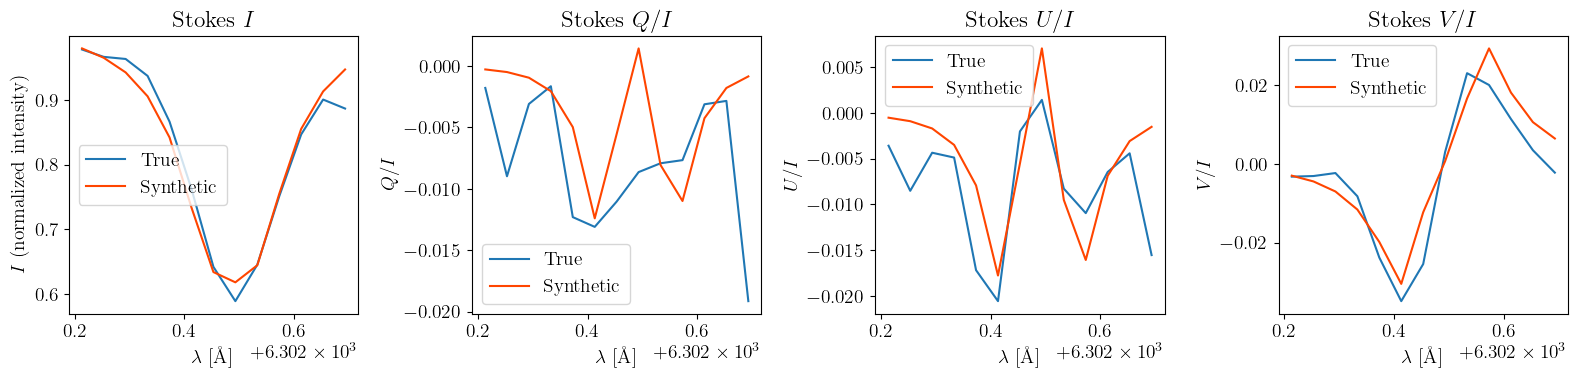

In [10]:
# Plot results for the first pixel of map 0
plot_stokes(map_inv_dict[0], syn_spectra_map_dict[0], np.array(regions_dict[0][0][0]), int(0), int(0), stokes_labels)

In [11]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:',device)
print('Pytorch version:',torch.__version__)
if torch.cuda.is_available() is True:
    print(f'Device type: {torch.cuda.get_device_name(0)}')

Device: cpu
Pytorch version: 2.1.0+cu121


# Train the normalizing flow
## Define training and testing datasets, dataloaders and train the flow

In [11]:
# Dictionary to save important information
class dictionary(dict): 
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [12]:
# Instantiate params dictionary
settings = dictionary()

In [13]:
# Reshape training data
spectra_map0 = map_inv_dict[0].reshape(map_inv_dict[0].shape[0]*map_inv_dict[0].shape[1], map_inv_dict[0].shape[2]*map_inv_dict[0].shape[3])
parameters_map0 = inverted_map_dict[0].reshape(inverted_map_dict[0].shape[0]*inverted_map_dict[0].shape[1], inverted_map_dict[0].shape[2])

# Create datasets of training data
spectra = spectra_map0
parameters = parameters_map0

In [14]:
# Define test map data
spectra_testmap = map_inv_dict[1]
parameters_testmap = inverted_map_dict[1]

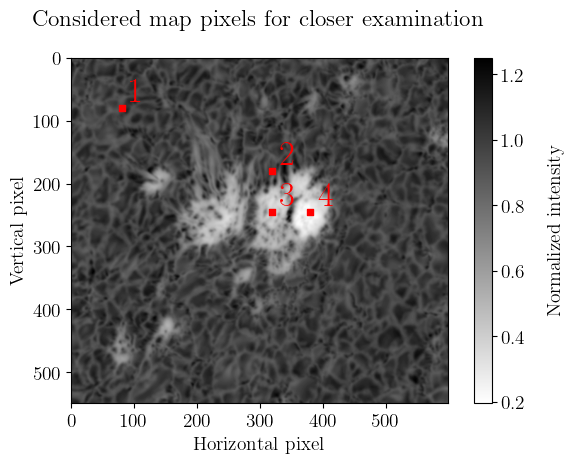

In [15]:
# Show, which pixels are to be examined
plt.title('Considered map pixels for closer examination\n')
plt.imshow(spectra_testmap[:,:,0,0], cmap='binary')  # Assuming it's a grayscale image
plt.xlabel('Horizontal pixel')
plt.ylabel('Vertical pixel')
plt.colorbar().set_label('Normalized intensity', rotation=90, labelpad=15)

# Specify the coordinates and labels of the pixels you want to highlight
highlighted_pixels = [(80, 80, '1'), (320, 180, '2'), (320, 245, '3'), (380, 245, '4')]

# Annotate the highlighted pixels with red squares
for x, y, label in highlighted_pixels:
    plt.scatter(x, y, color='red', s=20, marker='s')  # Use square marker
    plt.annotate(label, (x, y), color='red', fontsize=25, ha='center', va='center', xytext=(x+25, y-25))

# Show the plot
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-6-considered-map-pixels-nflows-piecewisequadratic.pdf')
plt.show()

In [16]:
# Store selected pixel data 1
expval1 = parameters_testmap[80,80,:]
expobs1 = spectra_testmap[80,80,:,:].reshape(4*13)

# Store selected pixel data 2
expval2 = parameters_testmap[320,180,:]
expobs2 = spectra_testmap[320,180,:,:].reshape(4*13)

# Store selected pixel data 3
expval3 = parameters_testmap[320,245,:]
expobs3 = spectra_testmap[320,245,:,:].reshape(4*13)

# Store selected pixel data 4
expval4 = parameters_testmap[380,245,:]
expobs4 = spectra_testmap[380,245,:,:].reshape(4*13)

In [17]:
# Print shape of data
print(f'Shape of true spectra data is: {spectra.shape}')
print(f'Shape of true parameters data is: {parameters.shape}')

Shape of true spectra data is: (330000, 52)
Shape of true parameters data is: (330000, 9)


In [18]:
# Test for NaN values in data
has_nan = np.isnan(spectra).any()
if has_nan==False:
    has_nan = np.isnan(parameters).any()

if has_nan:
    print('The data contain NaN values.')
else:
    print('The data do not contain any NaN values.')

The data do not contain any NaN values.


In [19]:
# Define input x and context y
x = parameters # parameters
y = spectra # spectra

# Make training and testing splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Standardize the input x and context y for training dataset
x_scaler_train = StandardScaler().fit(x_train)
y_scaler_train = StandardScaler().fit(y_train)
x_std_train = x_scaler_train.transform(x_train)
y_std_train = y_scaler_train.transform(y_train)

# Standardize the input x and context y for testing dataset
x_scaler_test = StandardScaler().fit(x_test)
y_scaler_test = StandardScaler().fit(y_test)
x_std_test = x_scaler_test.transform(x_test)
y_std_test = y_scaler_test.transform(y_test)

# Define base distribution z, such that z = f(x) for training dataset
z_train = MultivariateNormal(torch.zeros(x_std_train.shape[1]), torch.eye(x_std_train.shape[1])).rsample(sample_shape=(x_std_train.shape[0],)).detach().numpy()

# Define base distribution z, such that z = f(x) for testing dataset
z_test = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(x_std_test.shape[0],)).detach().numpy()

# Print shapes of training data
print(f'Input x_std_train shape: {x_std_train.shape}')
print(f'Context y_std_train shape: {y_std_train.shape}')
print(f'Output z_train shape: {z_train.shape}')

# Print shapes of testing data
print(f'Input x_std_test shape: {x_std_test.shape}')
print(f'Context y_std_test shape: {y_std_test.shape}')
print(f'Output z_test shape: {z_test.shape}')

Input x_std_train shape: (297000, 9)
Context y_std_train shape: (297000, 52)
Output z_train shape: (297000, 9)
Input x_std_test shape: (33000, 9)
Context y_std_test shape: (33000, 52)
Output z_test shape: (33000, 9)


In [20]:
# Convert training data to PyTorch tensors
x_std_train = torch.tensor(x_std_train, dtype=torch.float32) # Make input x to tensor
y_std_train = torch.tensor(y_std_train, dtype=torch.float32) # Make context y to tensor
z_train = torch.tensor(z_train, dtype=torch.float32) # Make target distribution to tensor

# Convert testing data to PyTorch tensors
x_std_test = torch.tensor(x_std_test, dtype=torch.float32) # Make input x to tensor
y_std_test = torch.tensor(y_std_test, dtype=torch.float32) # Make context y to tensor
z_test = torch.tensor(z_test, dtype=torch.float32) # Make target distribution to tensor

In [21]:
# Print sizes of training data
print(f'Size of x_std_train: {x_std_train.size()}')
print(f'Size of y_std_train: {y_std_train.size()}')
print(f'Size of z_train: {z_train.size()}')

# Print sizes of testing data
print(f'Size of x_std_test: {x_std_test.size()}')
print(f'Size of y_std_test: {y_std_test.size()}')
print(f'Size of z_test: {z_test.size()}')

Size of x_std_train: torch.Size([297000, 9])
Size of y_std_train: torch.Size([297000, 52])
Size of z_train: torch.Size([297000, 9])
Size of x_std_test: torch.Size([33000, 9])
Size of y_std_test: torch.Size([33000, 52])
Size of z_test: torch.Size([33000, 9])


In [22]:
# Define dataloaders for training and testing
settings.batch_size = 512
dataset_train = torch.utils.data.TensorDataset(x_std_train, y_std_train) # Input: x, context: y
dataset_test = torch.utils.data.TensorDataset(x_std_test, y_std_test) # Input: x, context: y
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=settings.batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=settings.batch_size, shuffle=True)

In [23]:
# Settings for model
settings.input_size = np.array(x_std_train).shape[1]
settings.context_size = np.array(y_std_train).shape[1]
settings.hidden_size = 16 # Try 32, 128
settings.num_layers = 5 # Try 5, 8

In [24]:
# Define functions for flow definitions
def PiecewiseRationalQuadraticCouplingTransform(iflow, input_size, hidden_size, context_size, num_blocks=1, activation=F.elu, num_bins=8):
    return transforms.PiecewiseRationalQuadraticCouplingTransform(
        mask=utils.create_alternating_binary_mask(input_size, even=(iflow % 2 == 0)),
        transform_net_create_fn=(lambda in_features, out_features: nets.ResidualNet(in_features=in_features, 
        out_features=out_features, hidden_features=hidden_size,context_features=context_size, num_blocks=num_blocks,activation=activation)),
        num_bins=num_bins, tails='linear', tail_bound=5, apply_unconditional_transform=False)

def create_linear_transform(param_dim):
    return transforms.CompositeTransform([
        transforms.RandomPermutation(features=param_dim),
        transforms.LULinear(param_dim, identity_init=True)])

In [25]:
# Instantiate the normalizing flow
base_dist = StandardNormal(shape=[settings.input_size])
flowtransforms = []
for _ in range(settings.num_layers):
    flowtransforms.append(create_linear_transform(param_dim=settings.input_size))
    flowtransforms.append(PiecewiseRationalQuadraticCouplingTransform(_, settings.input_size,
                                                                      settings.hidden_size, context_size=settings.context_size))
    flowtransforms.append(create_linear_transform(param_dim=settings.input_size))
flowtransforms = CompositeTransform(flowtransforms)

flow = Flow(flowtransforms, base_dist)

In [26]:
# Settings for training
settings.learning_rate = 1e-3
settings.scheduling_rate = 0.999
settings.num_epochs = 10

# Define optimizer and scheduler
optimizer = torch.optim.Adam(flow.parameters(), lr=settings.learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, settings.scheduling_rate)

In [27]:
# Train the flow
train_losses = []
test_losses = []
epochs = []
for epoch in range(settings.num_epochs):
    epoch_train_losses = []
    epoch_test_losses = []
    for batch_x, batch_y in dataloader_train:
        flow.train()
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=batch_x, context=batch_y).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_losses.append(loss.detach())
    for batch_x, batch_y in dataloader_test:
        flow.eval()
        loss = -flow.log_prob(inputs=batch_x, context=batch_y).mean()
        epoch_test_losses.append(loss.detach())
    epoch_train_loss = sum(epoch_train_losses)/len(dataset_train)
    epoch_test_loss = sum(epoch_test_losses)/len(dataset_test)
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    epochs.append(epoch)
    if (epoch+1) % 1 == 0:
        print('Epoch {}/{} train loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_train_loss))
        print('Epoch {}/{} test loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_test_loss))

Epoch 1/10 train loss: 0.0022
Epoch 1/10 test loss: -0.0049
Epoch 2/10 train loss: -0.0076
Epoch 2/10 test loss: -0.0088
Epoch 3/10 train loss: -0.0096
Epoch 3/10 test loss: -0.0099
Epoch 4/10 train loss: -0.0107
Epoch 4/10 test loss: -0.0108
Epoch 5/10 train loss: -0.0113
Epoch 5/10 test loss: -0.0112
Epoch 6/10 train loss: -0.0116
Epoch 6/10 test loss: -0.0113
Epoch 7/10 train loss: -0.0118
Epoch 7/10 test loss: -0.0115
Epoch 8/10 train loss: -0.0119
Epoch 8/10 test loss: -0.0116
Epoch 9/10 train loss: -0.0119
Epoch 9/10 test loss: -0.0116
Epoch 10/10 train loss: -0.0120
Epoch 10/10 test loss: -0.0116


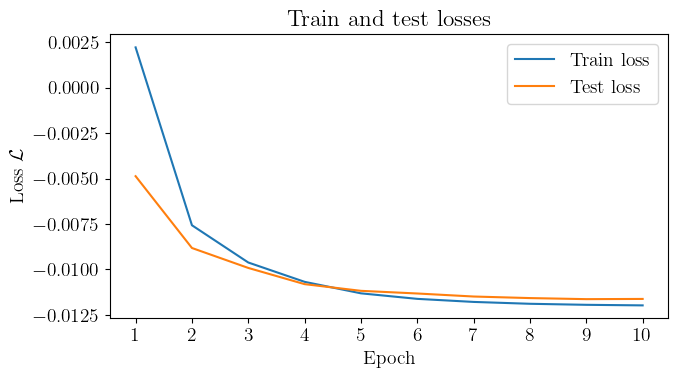

In [28]:
# Print train and test losses
plt.figure(figsize=(7,4))
plt.title('Train and test losses')
plt.xlabel('Epoch')
plt.ylabel('Loss $\\mathcal{L}$')
x_ticks = np.array(epochs) + 1
ticks_param = int(len(epochs)/settings.num_epochs)
selected_ticks = np.array(epochs)[::ticks_param]
plt.xticks(selected_ticks, x_ticks[selected_ticks])
plt.plot(np.array(epochs), train_losses, label='Train loss')
plt.plot(np.array(epochs), test_losses, label='Test loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-6-loss-nflows-piecewisequadratic.pdf')

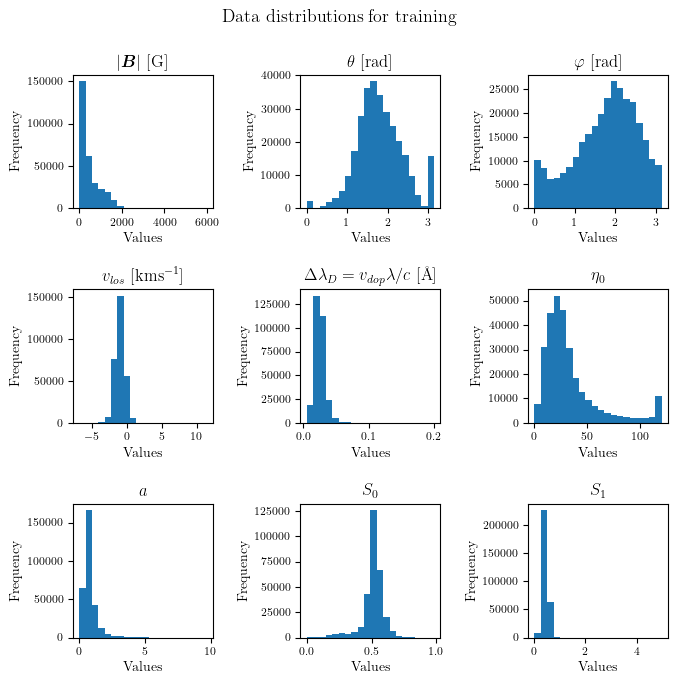

In [29]:
# Plot histogram of training data
plot_histograms(x_train, l_units, 'Data distributions for training', savename='nf-milne-eddington-example-6-datadistributiontraining-nflows-piecewisequadratic.pdf')

# Test the trained normalizing flow

In [30]:
# Set number of samples
settings.exp_samples = 5000

In [31]:
# Calculate minimum, maximund and mean values of parameters in this example
min_x = np.min(parameters_map0, axis=0)
max_x = np.max(parameters_map0, axis=0)
mean_x = np.mean(parameters_map0, axis=0)

In [32]:
# Define scalers for test data
x_probe_scaler = StandardScaler().fit(parameters_testmap.reshape(parameters_testmap.shape[0]*parameters_testmap.shape[1], parameters_testmap.shape[2]))
y_probe_scaler = StandardScaler().fit(spectra_testmap.reshape(spectra_testmap.shape[0]*spectra_testmap.shape[1], spectra_testmap.shape[2]*spectra_testmap.shape[3]))

## NF and MCMC inversion of observation #1

/home/dz/.local/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2192.)
  outputs, _ = torch.triangular_solve(


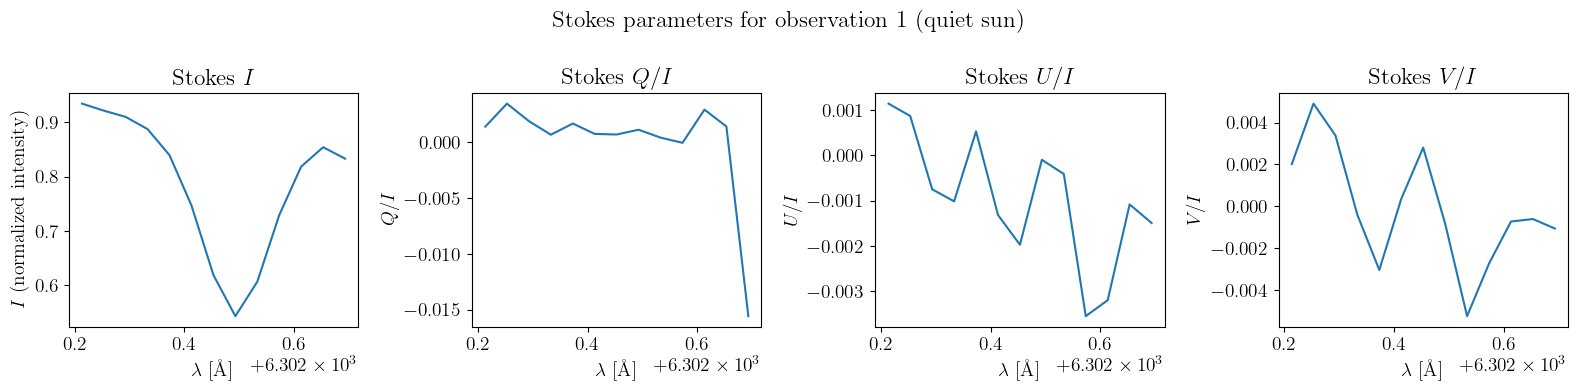

line::line: Initialized [6302.493100] ->   3 Zeeman components
  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]/home/dz/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.81it/s]


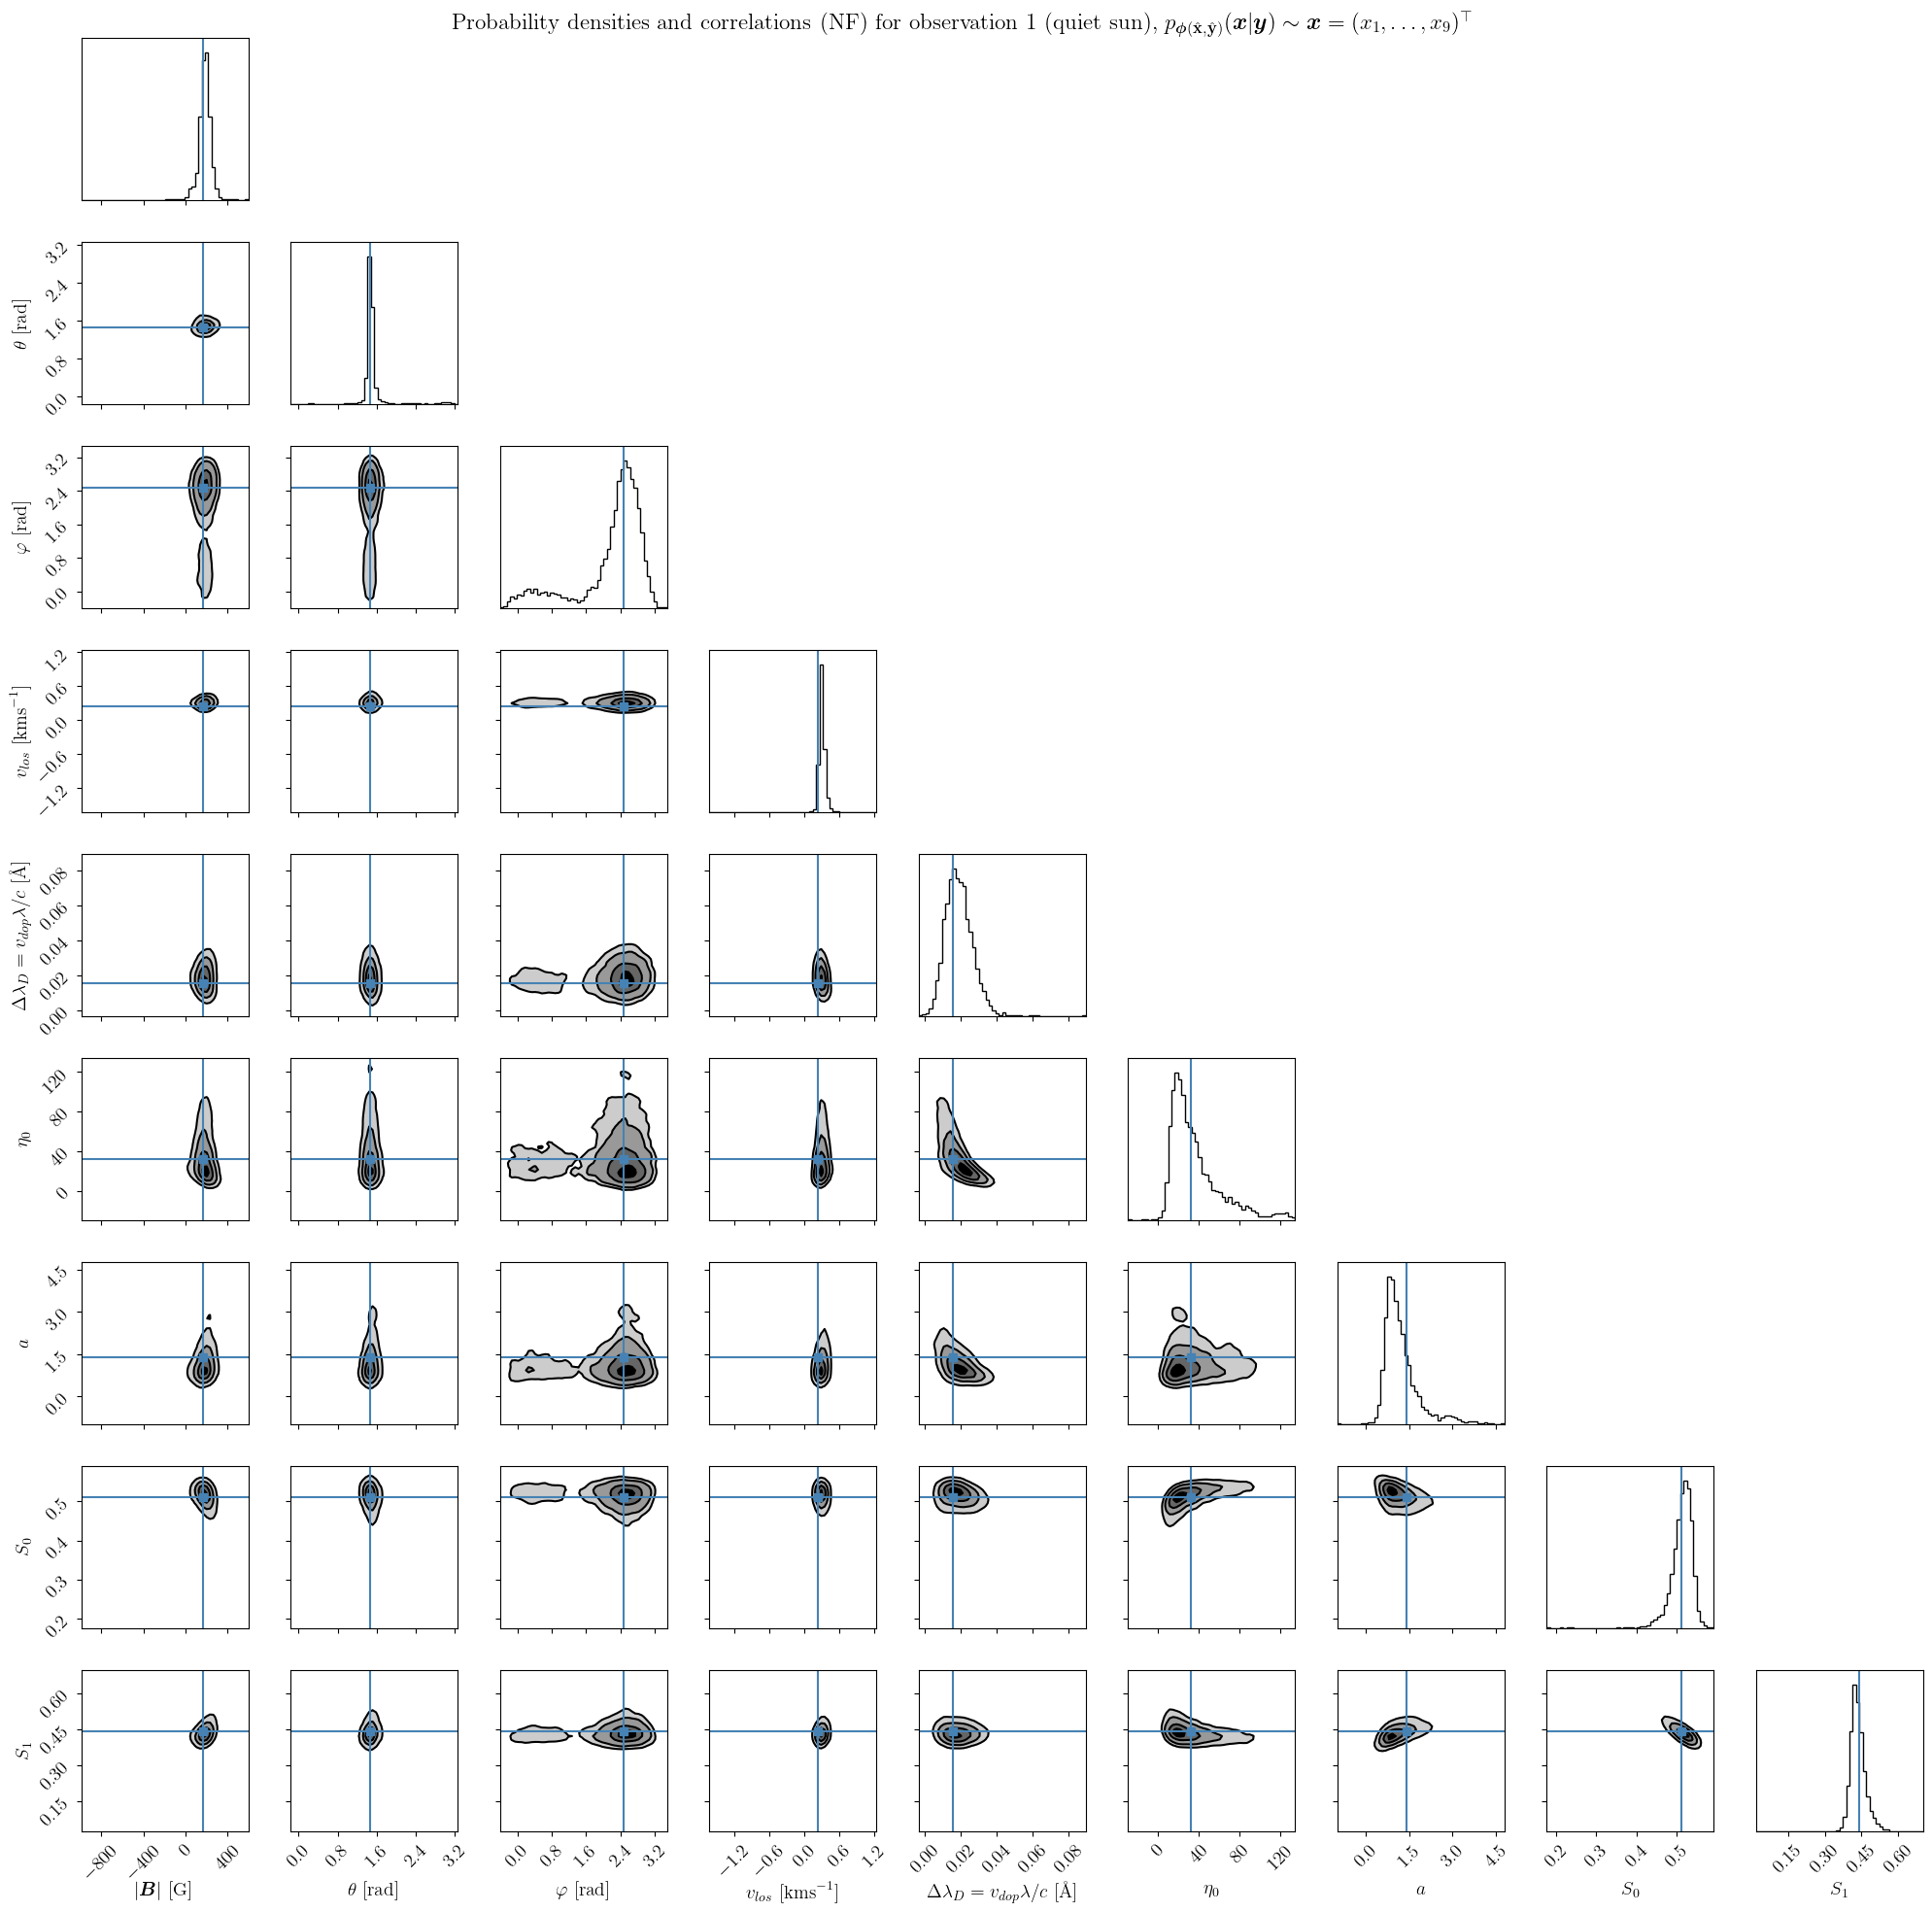

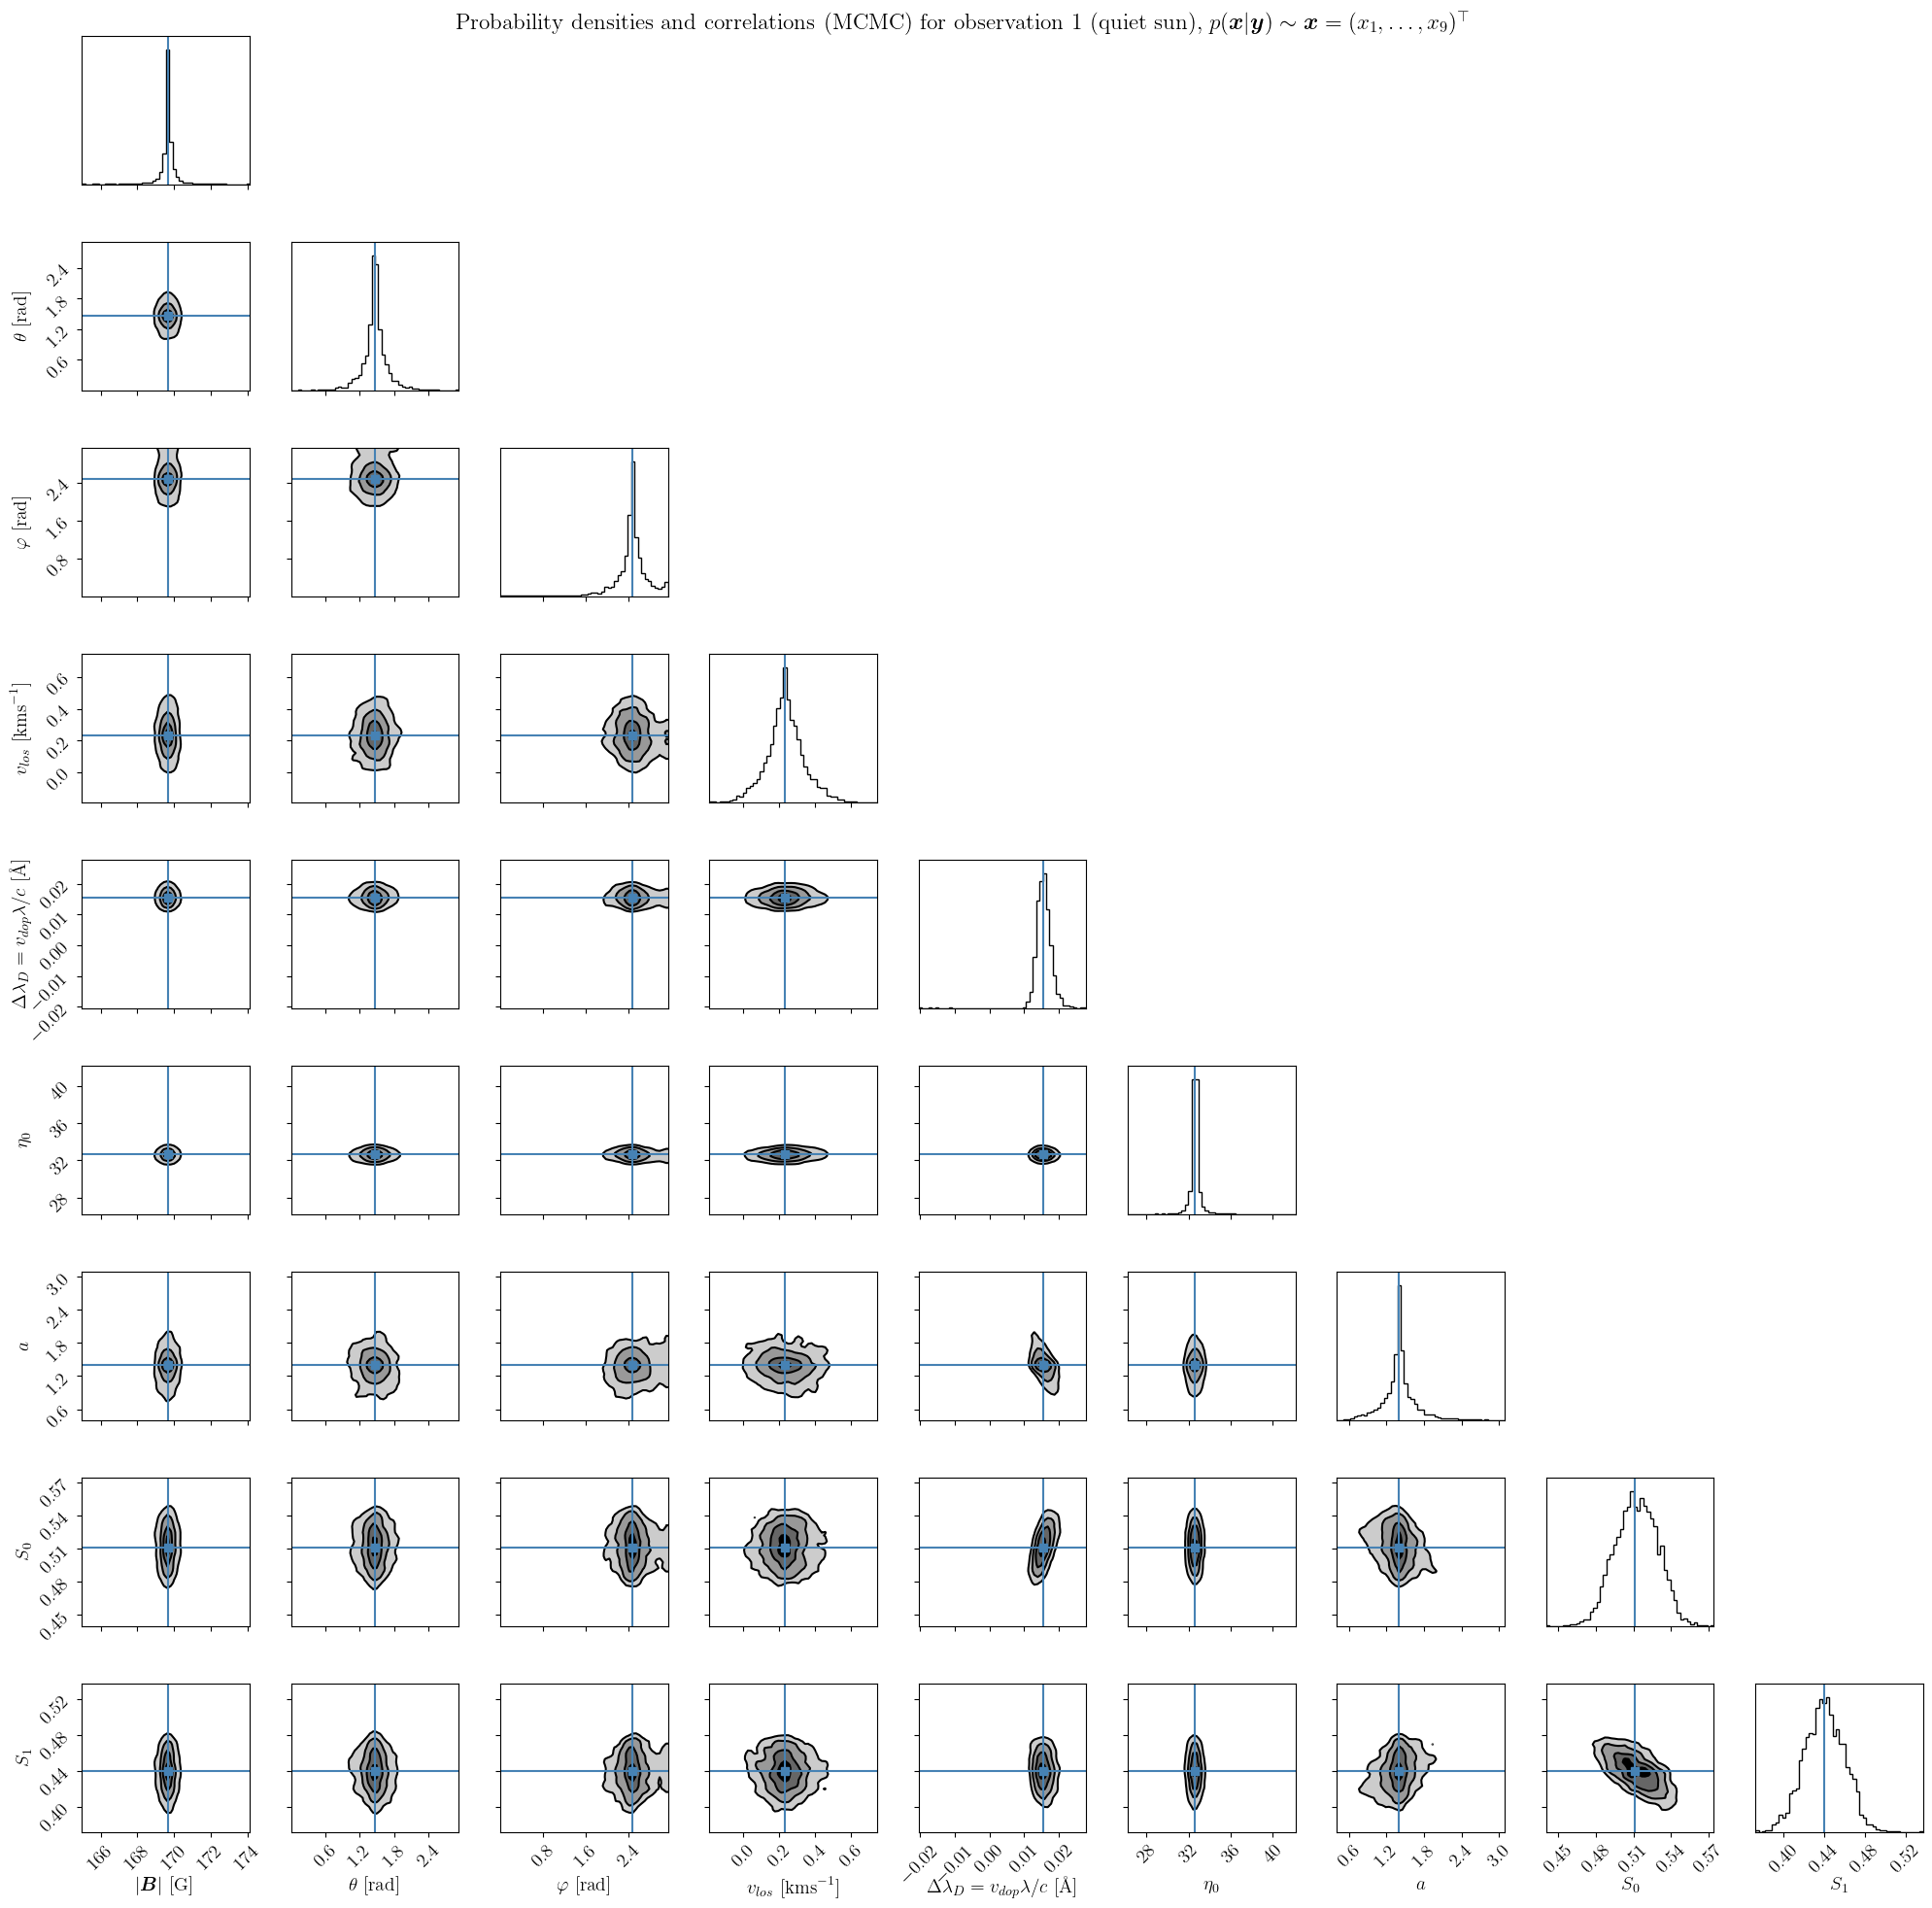

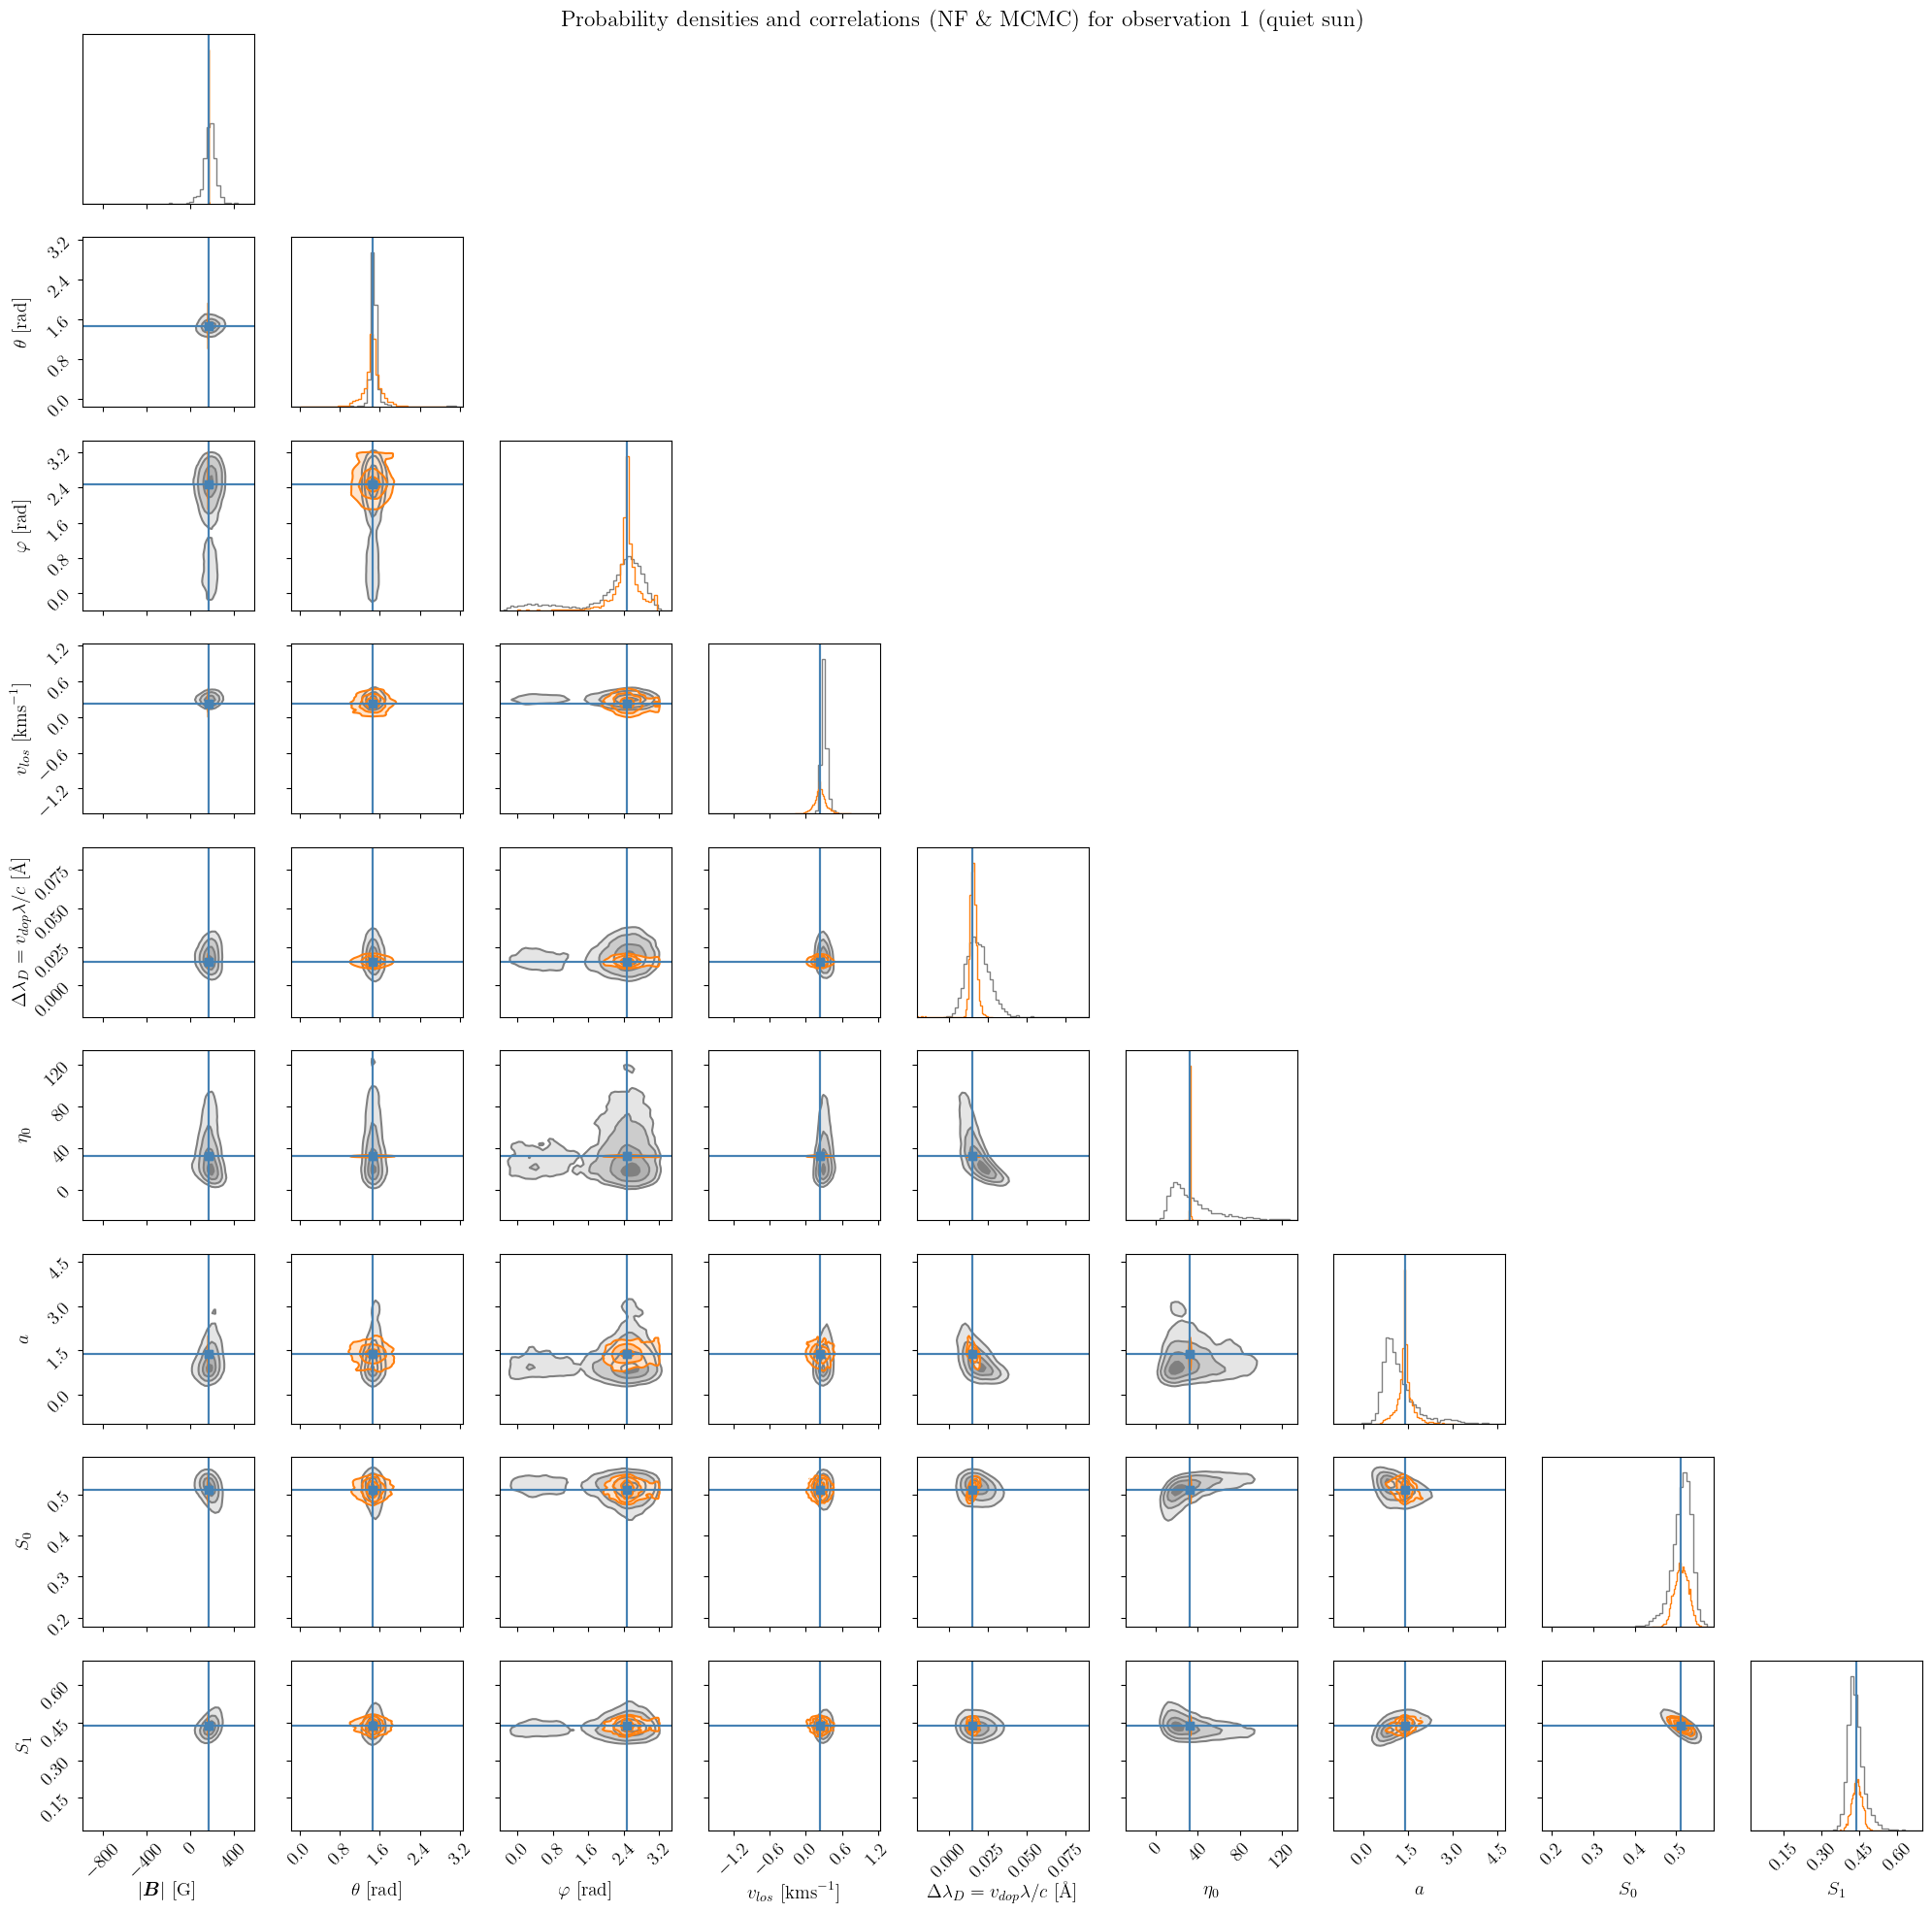

In [34]:
# Take test sample 1 (quiet sun)
expval = expval1
expobs = expobs1

z_exp = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(settings.exp_samples,))
y_exp = torch.tensor(np.repeat(expobs[None,:], 1, axis=0))
y_exp_std = torch.tensor(y_probe_scaler.transform(y_exp), dtype=torch.float32)

# Sample from the flow using the testobservation y_exp as context
rec_x_std = flow.sample(settings.exp_samples, context=y_exp_std)
rec_x_std = rec_x_std.detach().numpy()
rec_x_nf = x_probe_scaler.inverse_transform(rec_x_std[0])

# Plot Stokes profiles
plot_stokes_single(expobs, regions_dict[0][0][0], stokes_labels, title='Stokes parameters for observation 1 (quiet sun)', savename='nf-milne-eddington-example-6-corner-spectrum-1-nf-nflows-piecewisequadratic.pdf')

# Produce corner plot
figure = corner.corner(rec_x_nf, labels=l_units, truths=expval, show_titles=False, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
plt.suptitle('Probability densities and correlations (NF) for observation 1 (quiet sun), $p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{9})^\\top$')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-6-corner-1-nf-nflows-piecewisequadratic.pdf')

# Do MCMC sampling
mcmc_model = Bayesian_Inference(expval, min_x-0.1*mean_x, max_x+0.1*mean_x, noise=1e-2)
rec_x_mcmc = mcmc_model.sample()

# Produce corner plot
figure = corner.corner(rec_x_mcmc, labels=l_units, truths=expval, show_titles=False, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
plt.suptitle('Probability densities and correlations (MCMC) for observation 1 (quiet sun), $p(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{9})^\\top$')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-6-corner-1-mcmc-nflows-piecewisequadratic.pdf')

# Calculate weights
weights_nf = np.ones_like(rec_x_nf[:,0])/len(rec_x_nf[:,0])
weights_mcmc = np.ones_like(rec_x_mcmc[:,0])/len(rec_x_mcmc[:,0])

# Produce corner plot
figure = corner.corner(rec_x_nf, labels=l_units, truths=expval, show_titles=False, color='Gray', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, weights=weights_nf)
_ = corner.corner(rec_x_mcmc, labels=l_units, truths=expval, show_titles=False, color='C1', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, weights=weights_mcmc, fig=figure)
plt.suptitle('Probability densities and correlations (NF \& MCMC) for observation 1 (quiet sun)')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-6-corner-1-nf-mcmc-nflows-piecewisequadratic.pdf')

## NF and MCMC inversion of observation #2

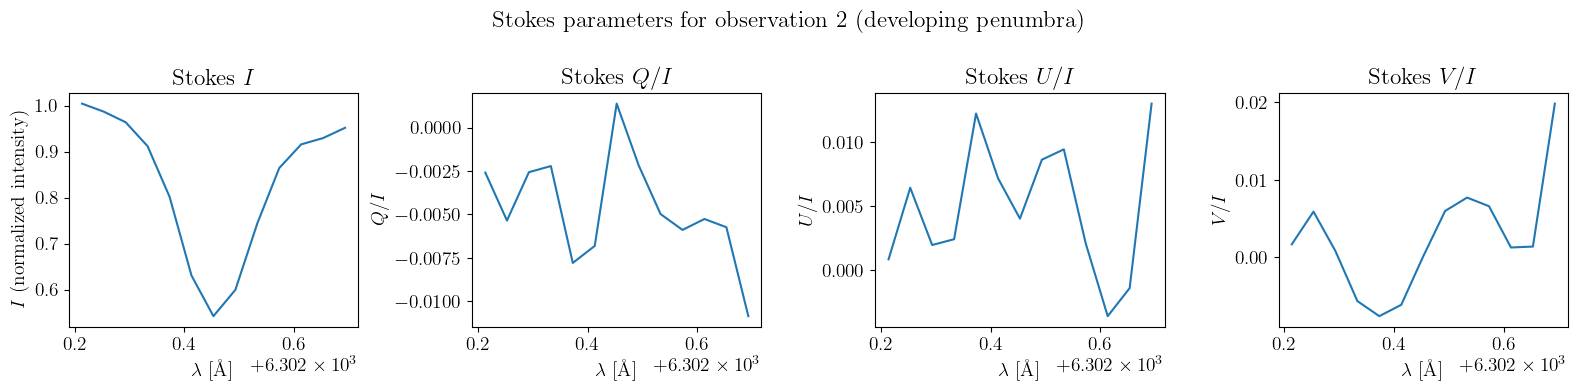

line::line: Initialized [6302.493100] ->   3 Zeeman components
  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]/home/dz/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.40it/s]


pyMilne::dealloc: cleaning-up...


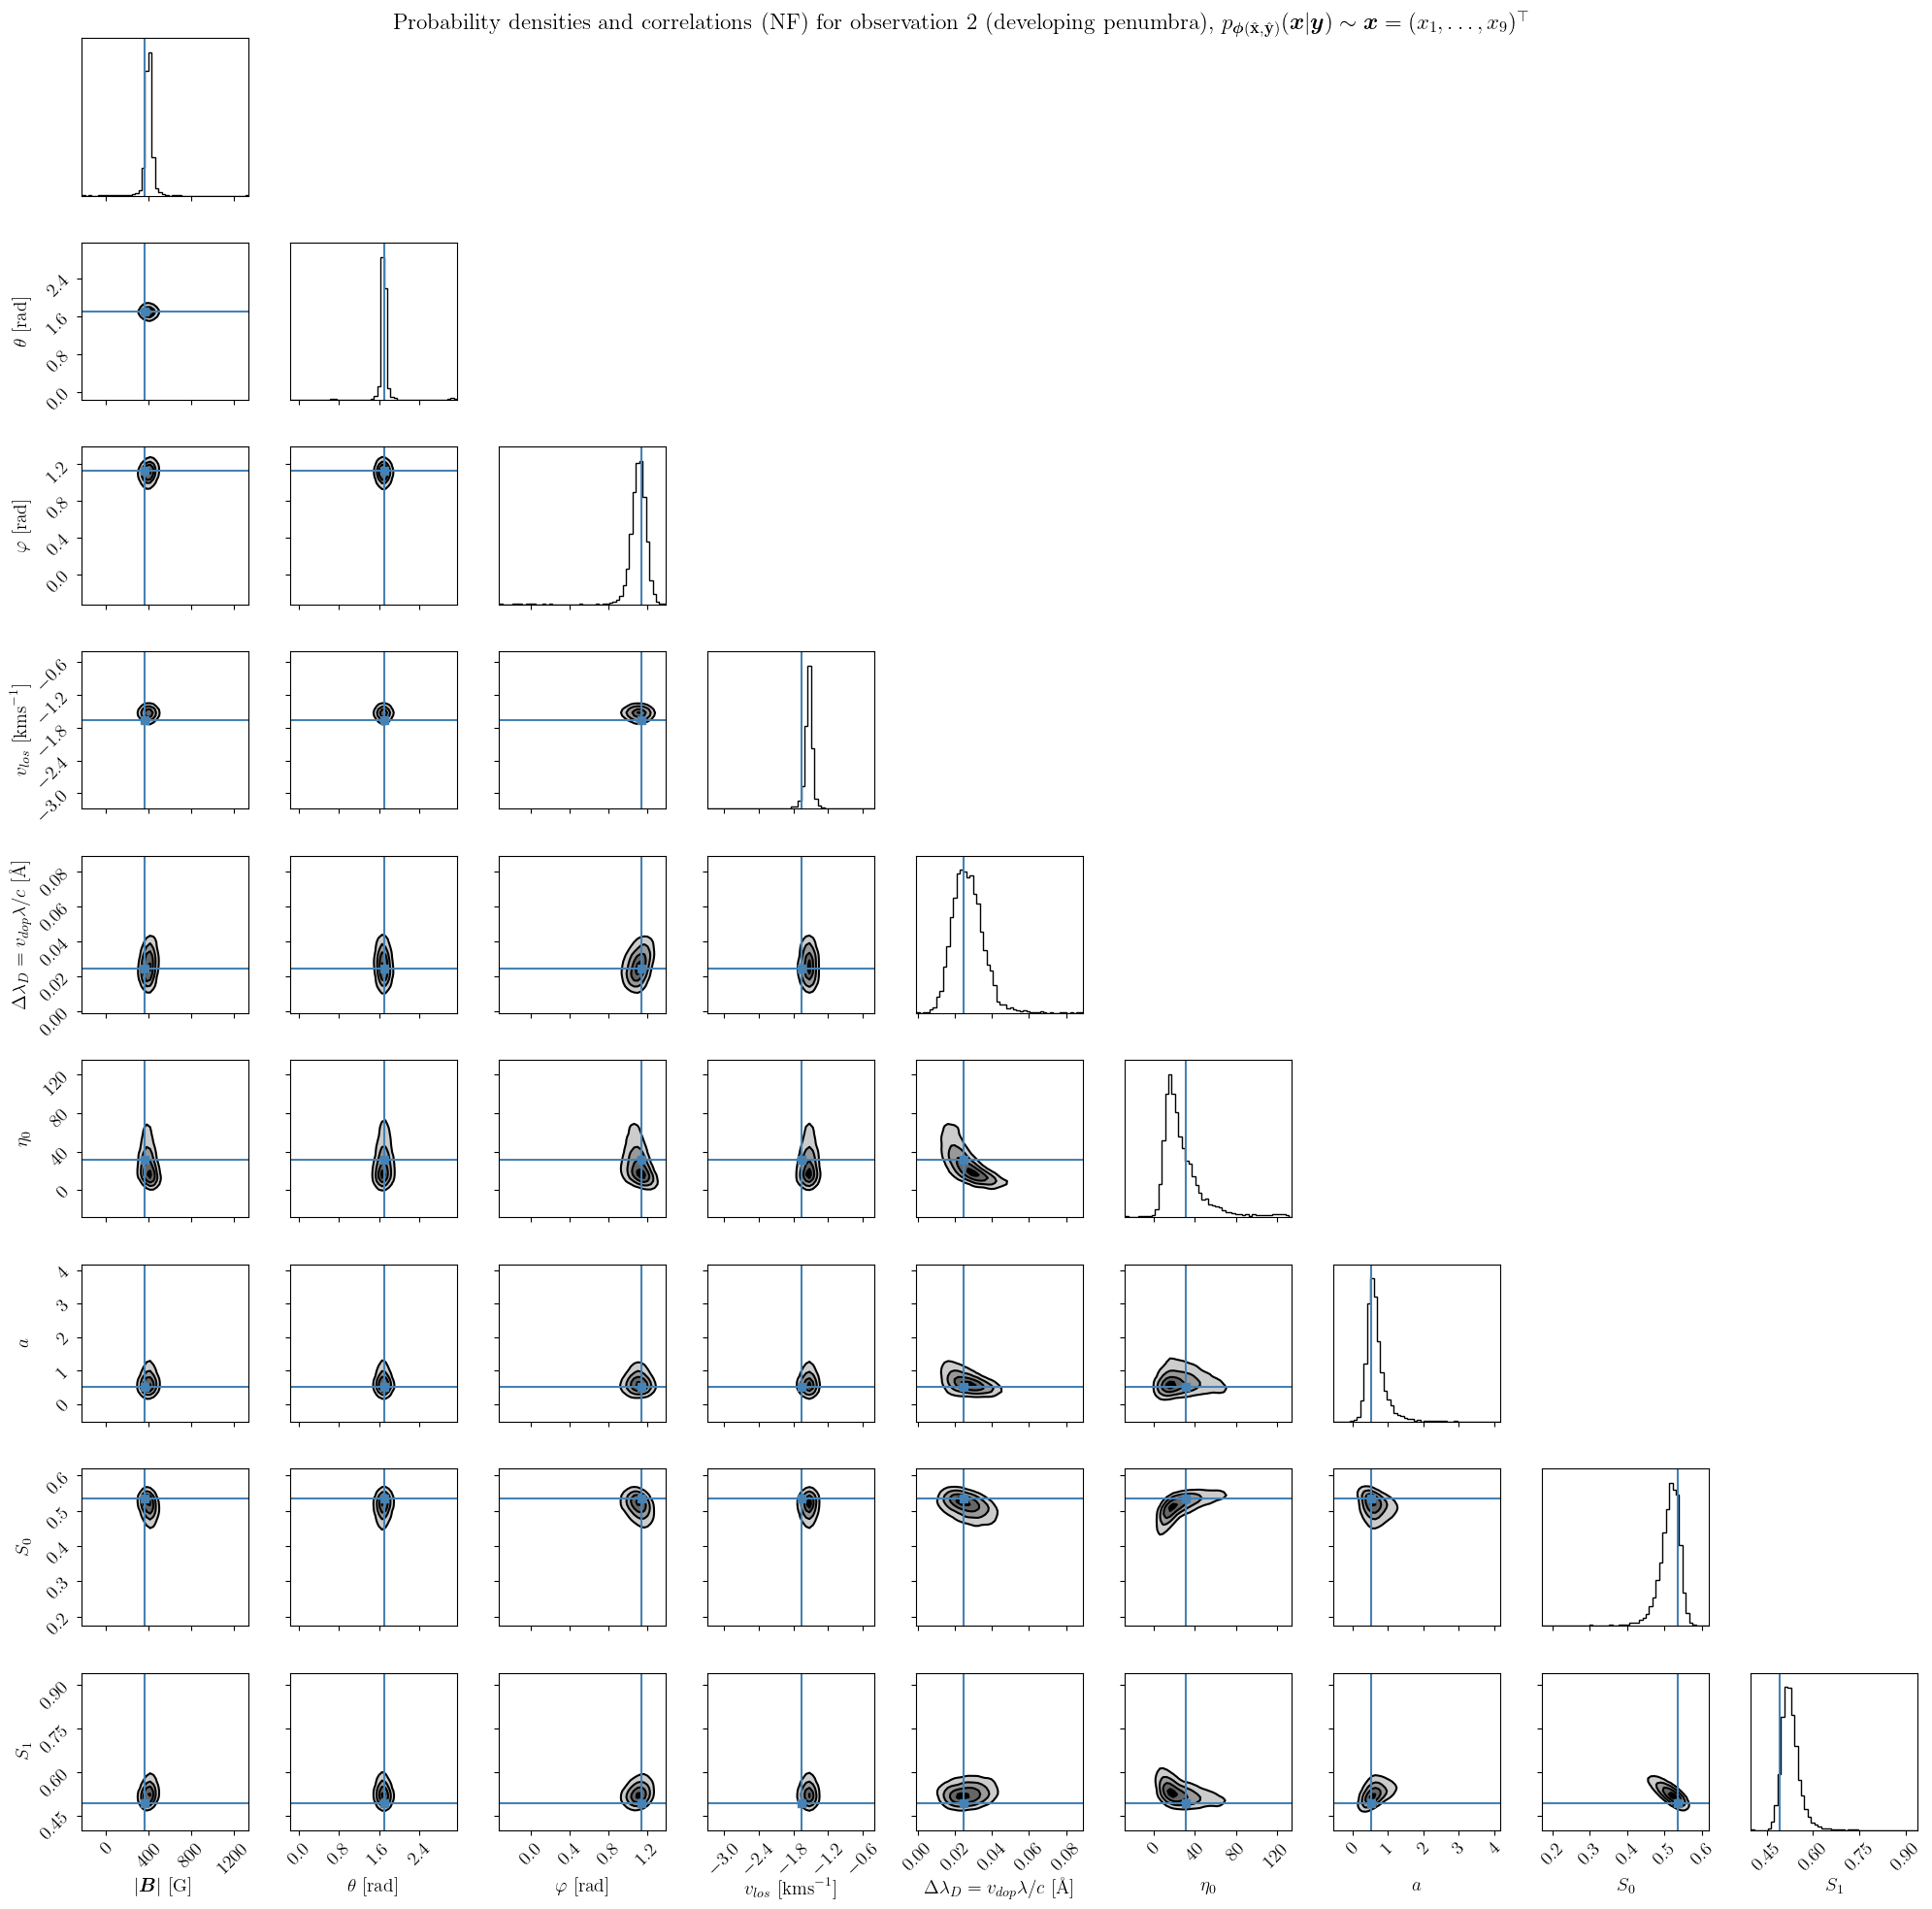

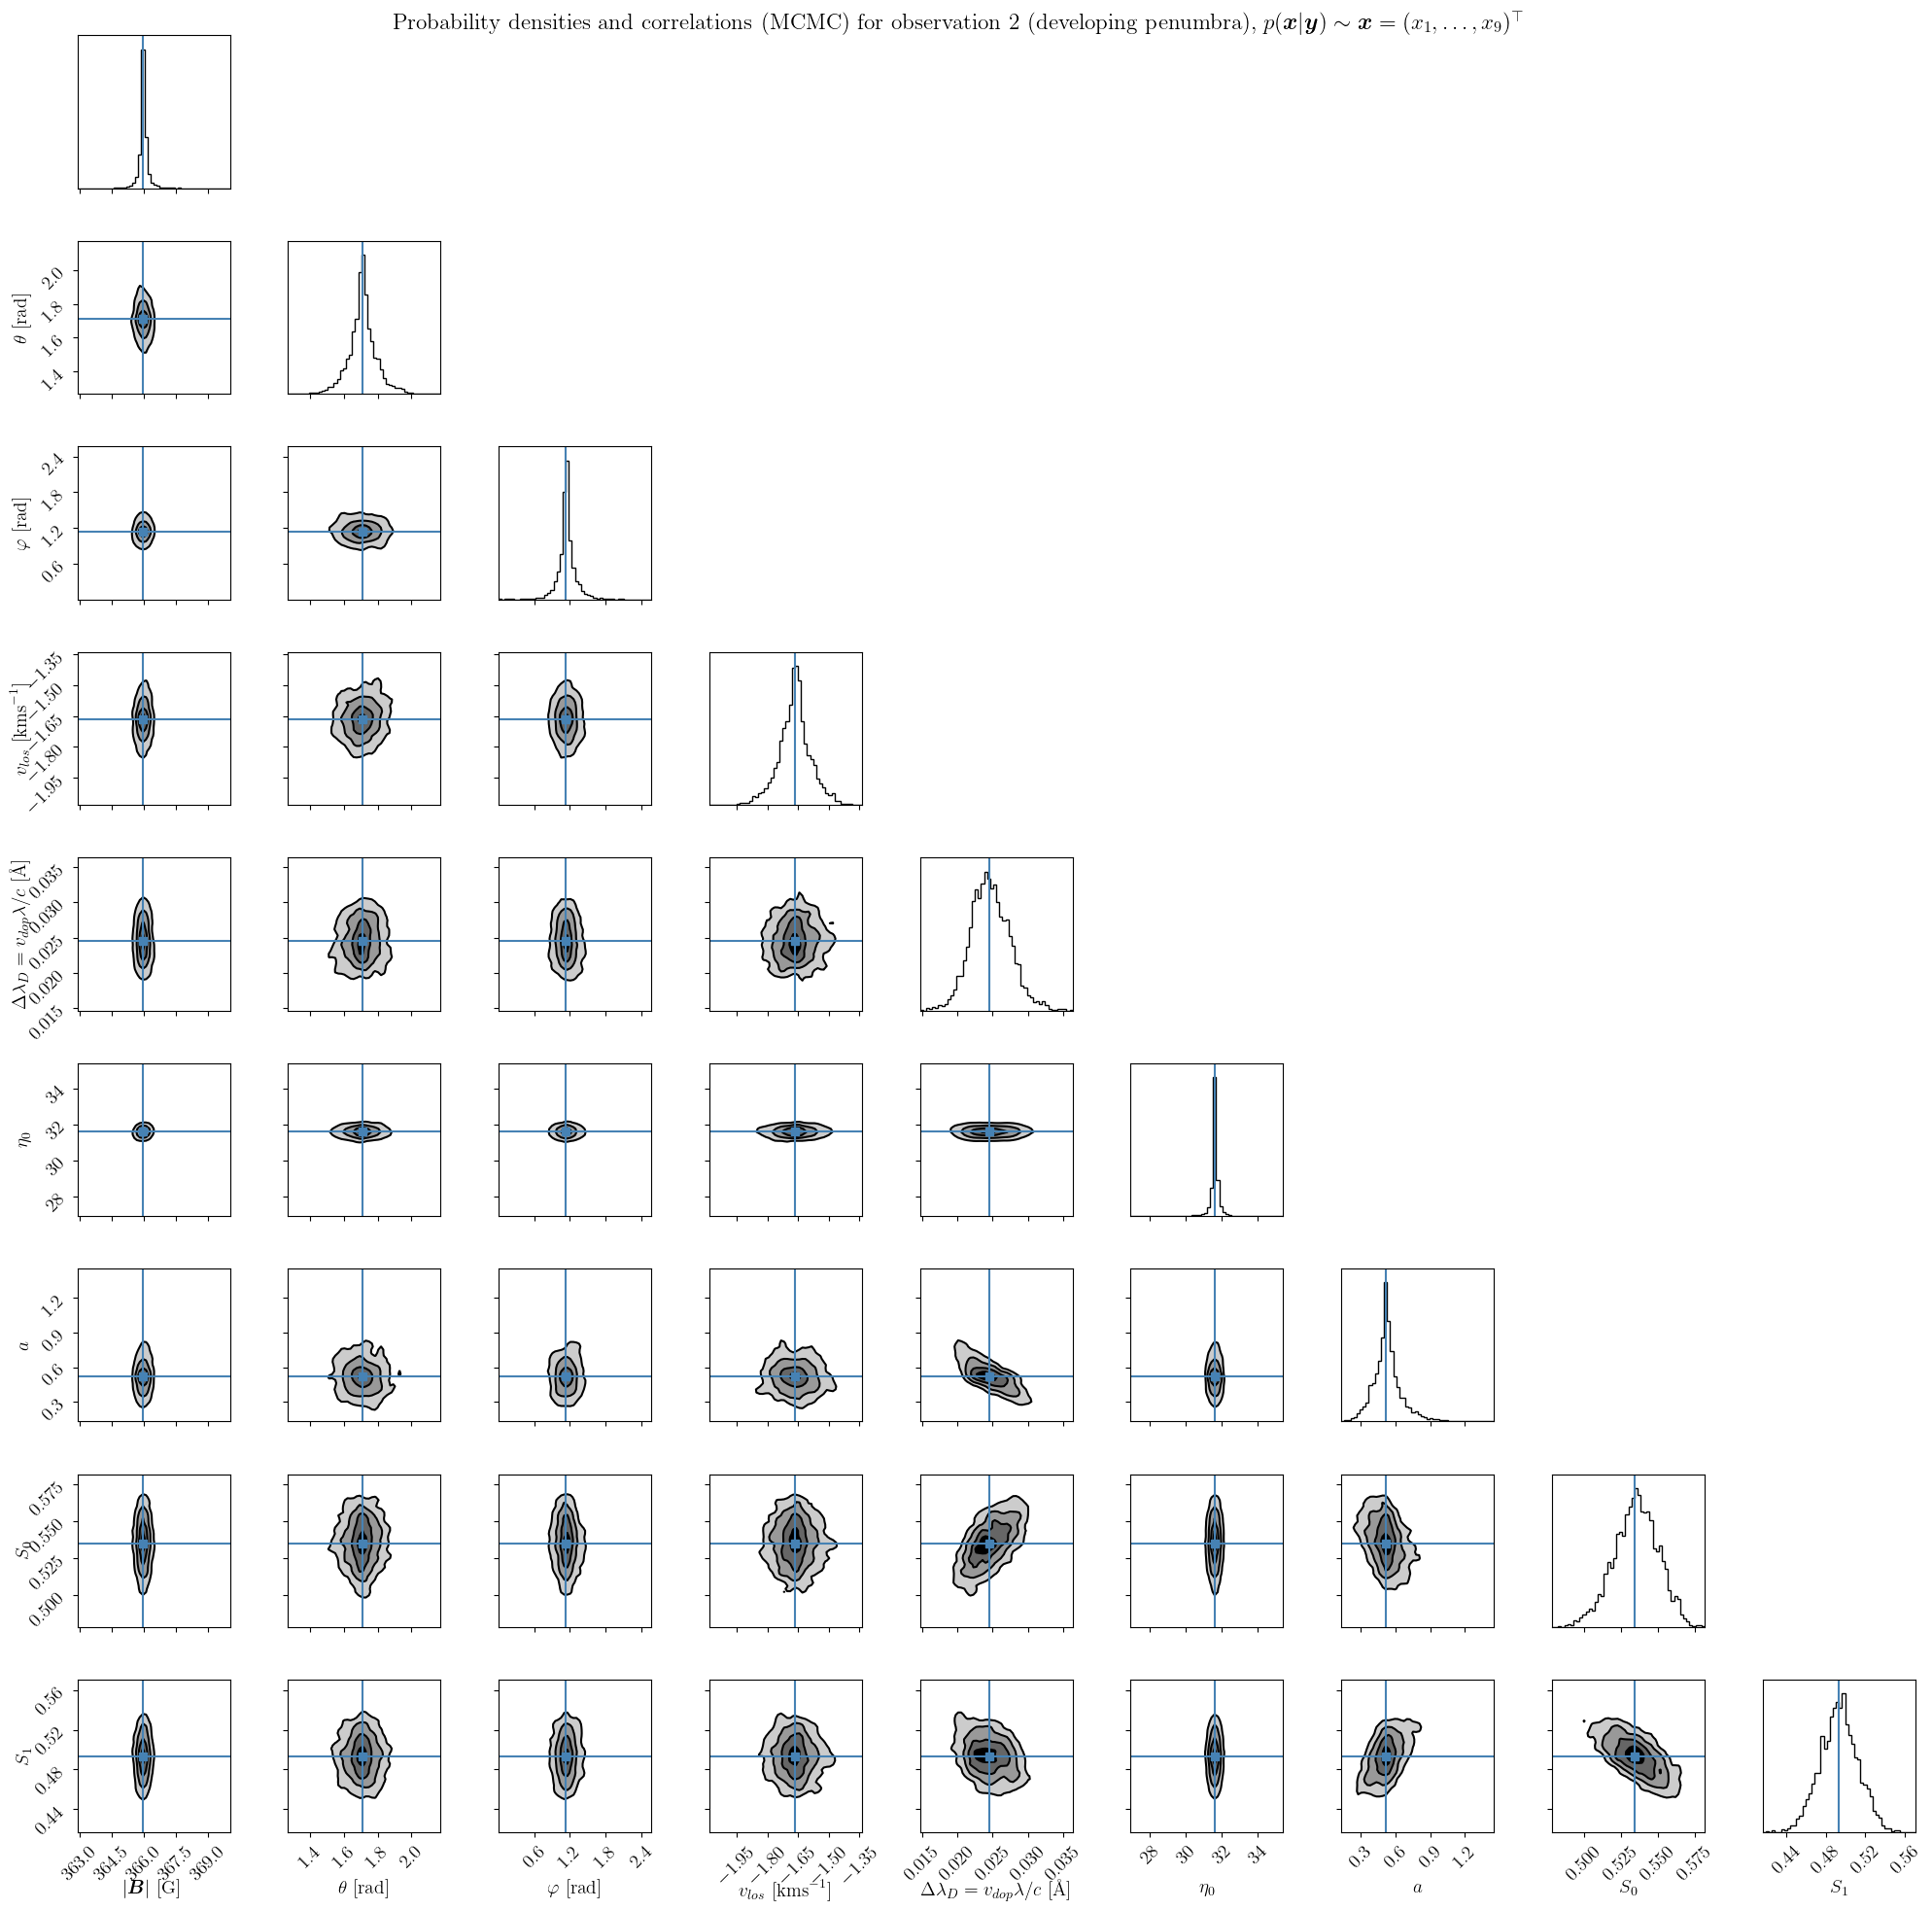

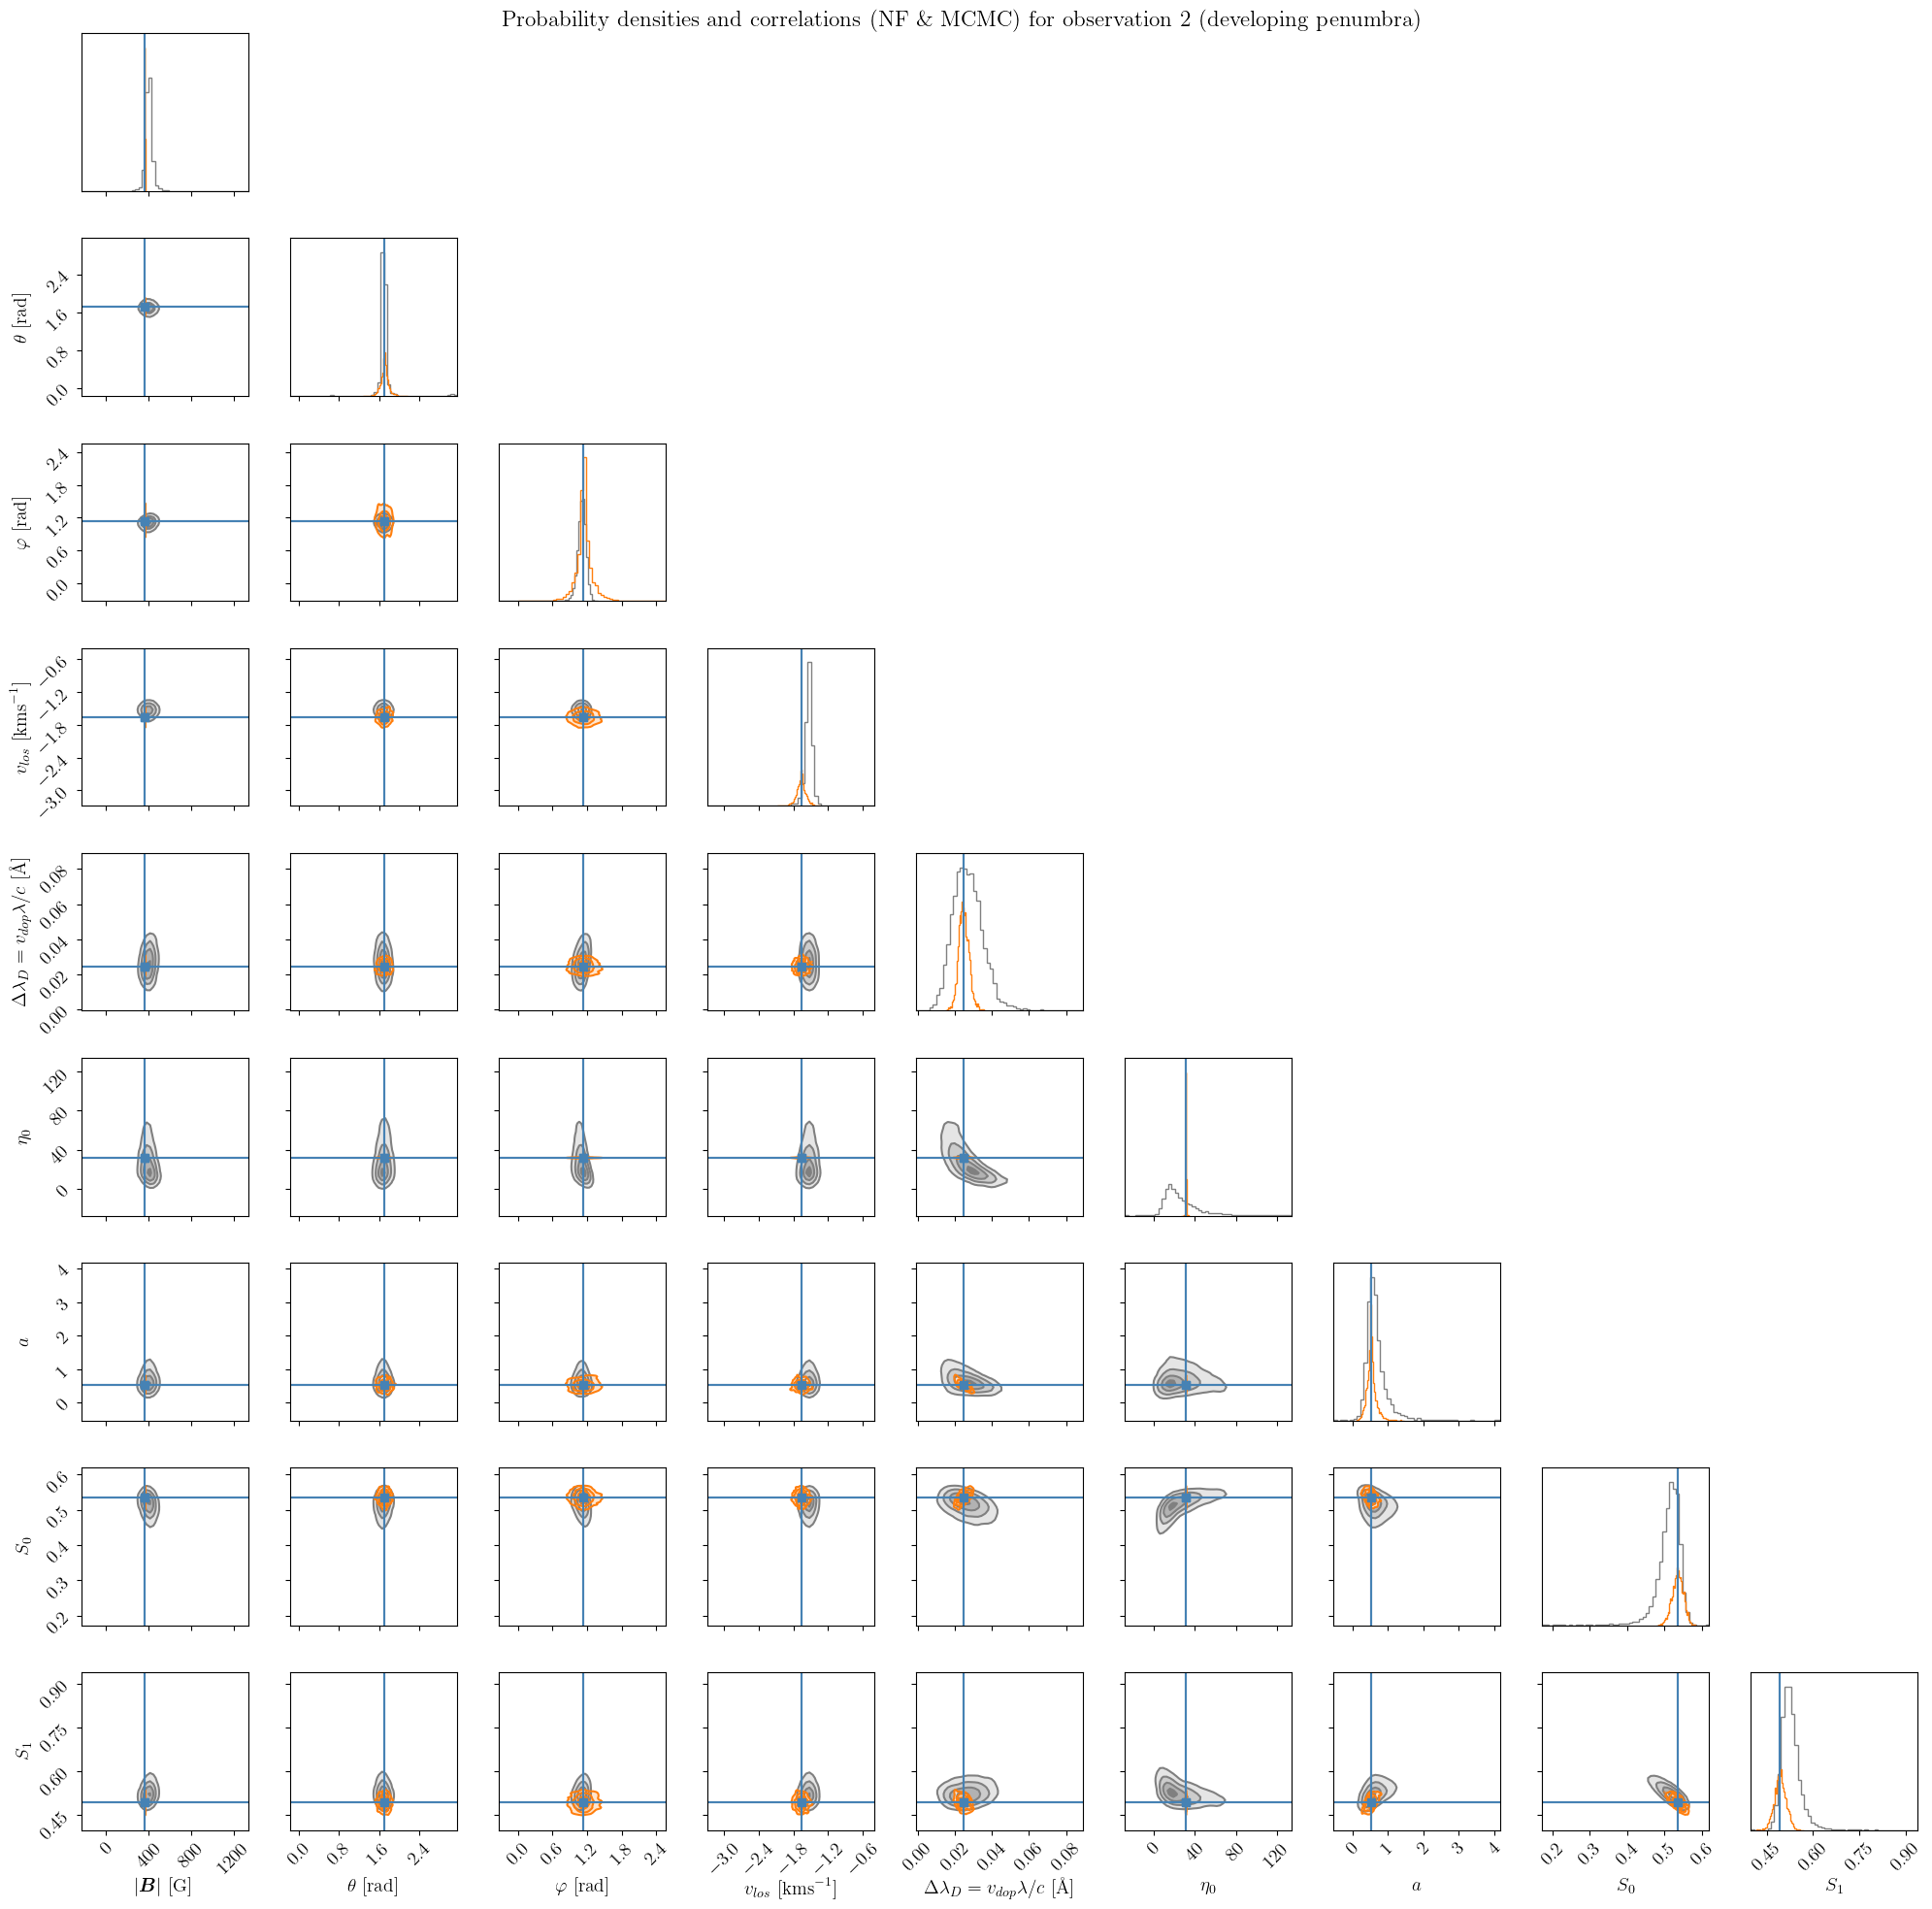

In [34]:
# Take test sample 1 (quiet sun)
expval = expval2
expobs = expobs2

z_exp = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(settings.exp_samples,))
y_exp = torch.tensor(np.repeat(expobs[None,:], 1, axis=0))
y_exp_std = torch.tensor(y_probe_scaler.transform(y_exp), dtype=torch.float32)

# Sample from the flow using the testobservation y_exp as context
rec_x_std = flow.sample(settings.exp_samples, context=y_exp_std)
rec_x_std = rec_x_std.detach().numpy()
rec_x_nf = x_probe_scaler.inverse_transform(rec_x_std[0])

# Plot Stokes profiles
plot_stokes_single(expobs, regions_dict[0][0][0], stokes_labels, title='Stokes parameters for observation 2 (developing penumbra)', savename='nf-milne-eddington-example-6-corner-spectrum-2-nf-nflows-piecewisequadratic.pdf')

# Produce corner plot
figure = corner.corner(rec_x_nf, labels=l_units, truths=expval, show_titles=False, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
plt.suptitle('Probability densities and correlations (NF) for observation 2 (developing penumbra), $p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{9})^\\top$')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-6-corner-2-nf-nflows-piecewisequadratic.pdf')

# Do MCMC sampling
mcmc_model = Bayesian_Inference(expval, min_x-0.1*mean_x, max_x+0.1*mean_x, noise=1e-2)
rec_x_mcmc = mcmc_model.sample()

# Produce corner plot
figure = corner.corner(rec_x_mcmc, labels=l_units, truths=expval, show_titles=False, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
plt.suptitle('Probability densities and correlations (MCMC) for observation 2 (developing penumbra), $p(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{9})^\\top$')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-6-corner-2-mcmc-nflows-piecewisequadratic.pdf')

# Calculate weights
weights_nf = np.ones_like(rec_x_nf[:,0])/len(rec_x_nf[:,0])
weights_mcmc = np.ones_like(rec_x_mcmc[:,0])/len(rec_x_mcmc[:,0])

# Produce corner plot
figure = corner.corner(rec_x_nf, labels=l_units, truths=expval, show_titles=False, color='Gray', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, weights=weights_nf)
_ = corner.corner(rec_x_mcmc, labels=l_units, truths=expval, show_titles=False, color='C1', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, weights=weights_mcmc, fig=figure)
plt.suptitle('Probability densities and correlations (NF \& MCMC) for observation 2 (developing penumbra)')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-6-corner-2-nf-mcmc-nflows-piecewisequadratic.pdf')

## NF and MCMC inversion of observation #3

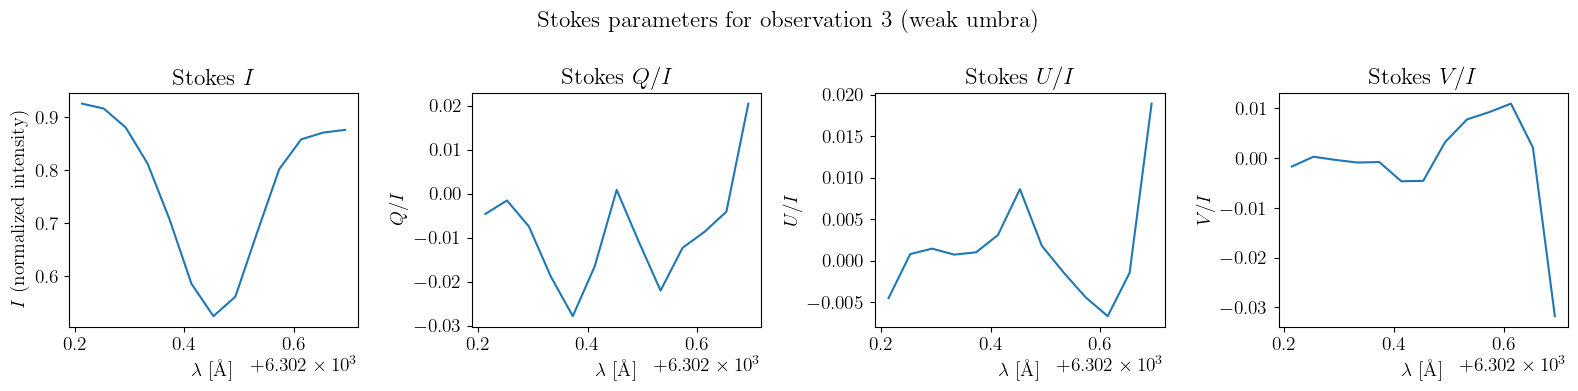

line::line: Initialized [6302.493100] ->   3 Zeeman components
  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]/home/dz/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.67it/s]


pyMilne::dealloc: cleaning-up...


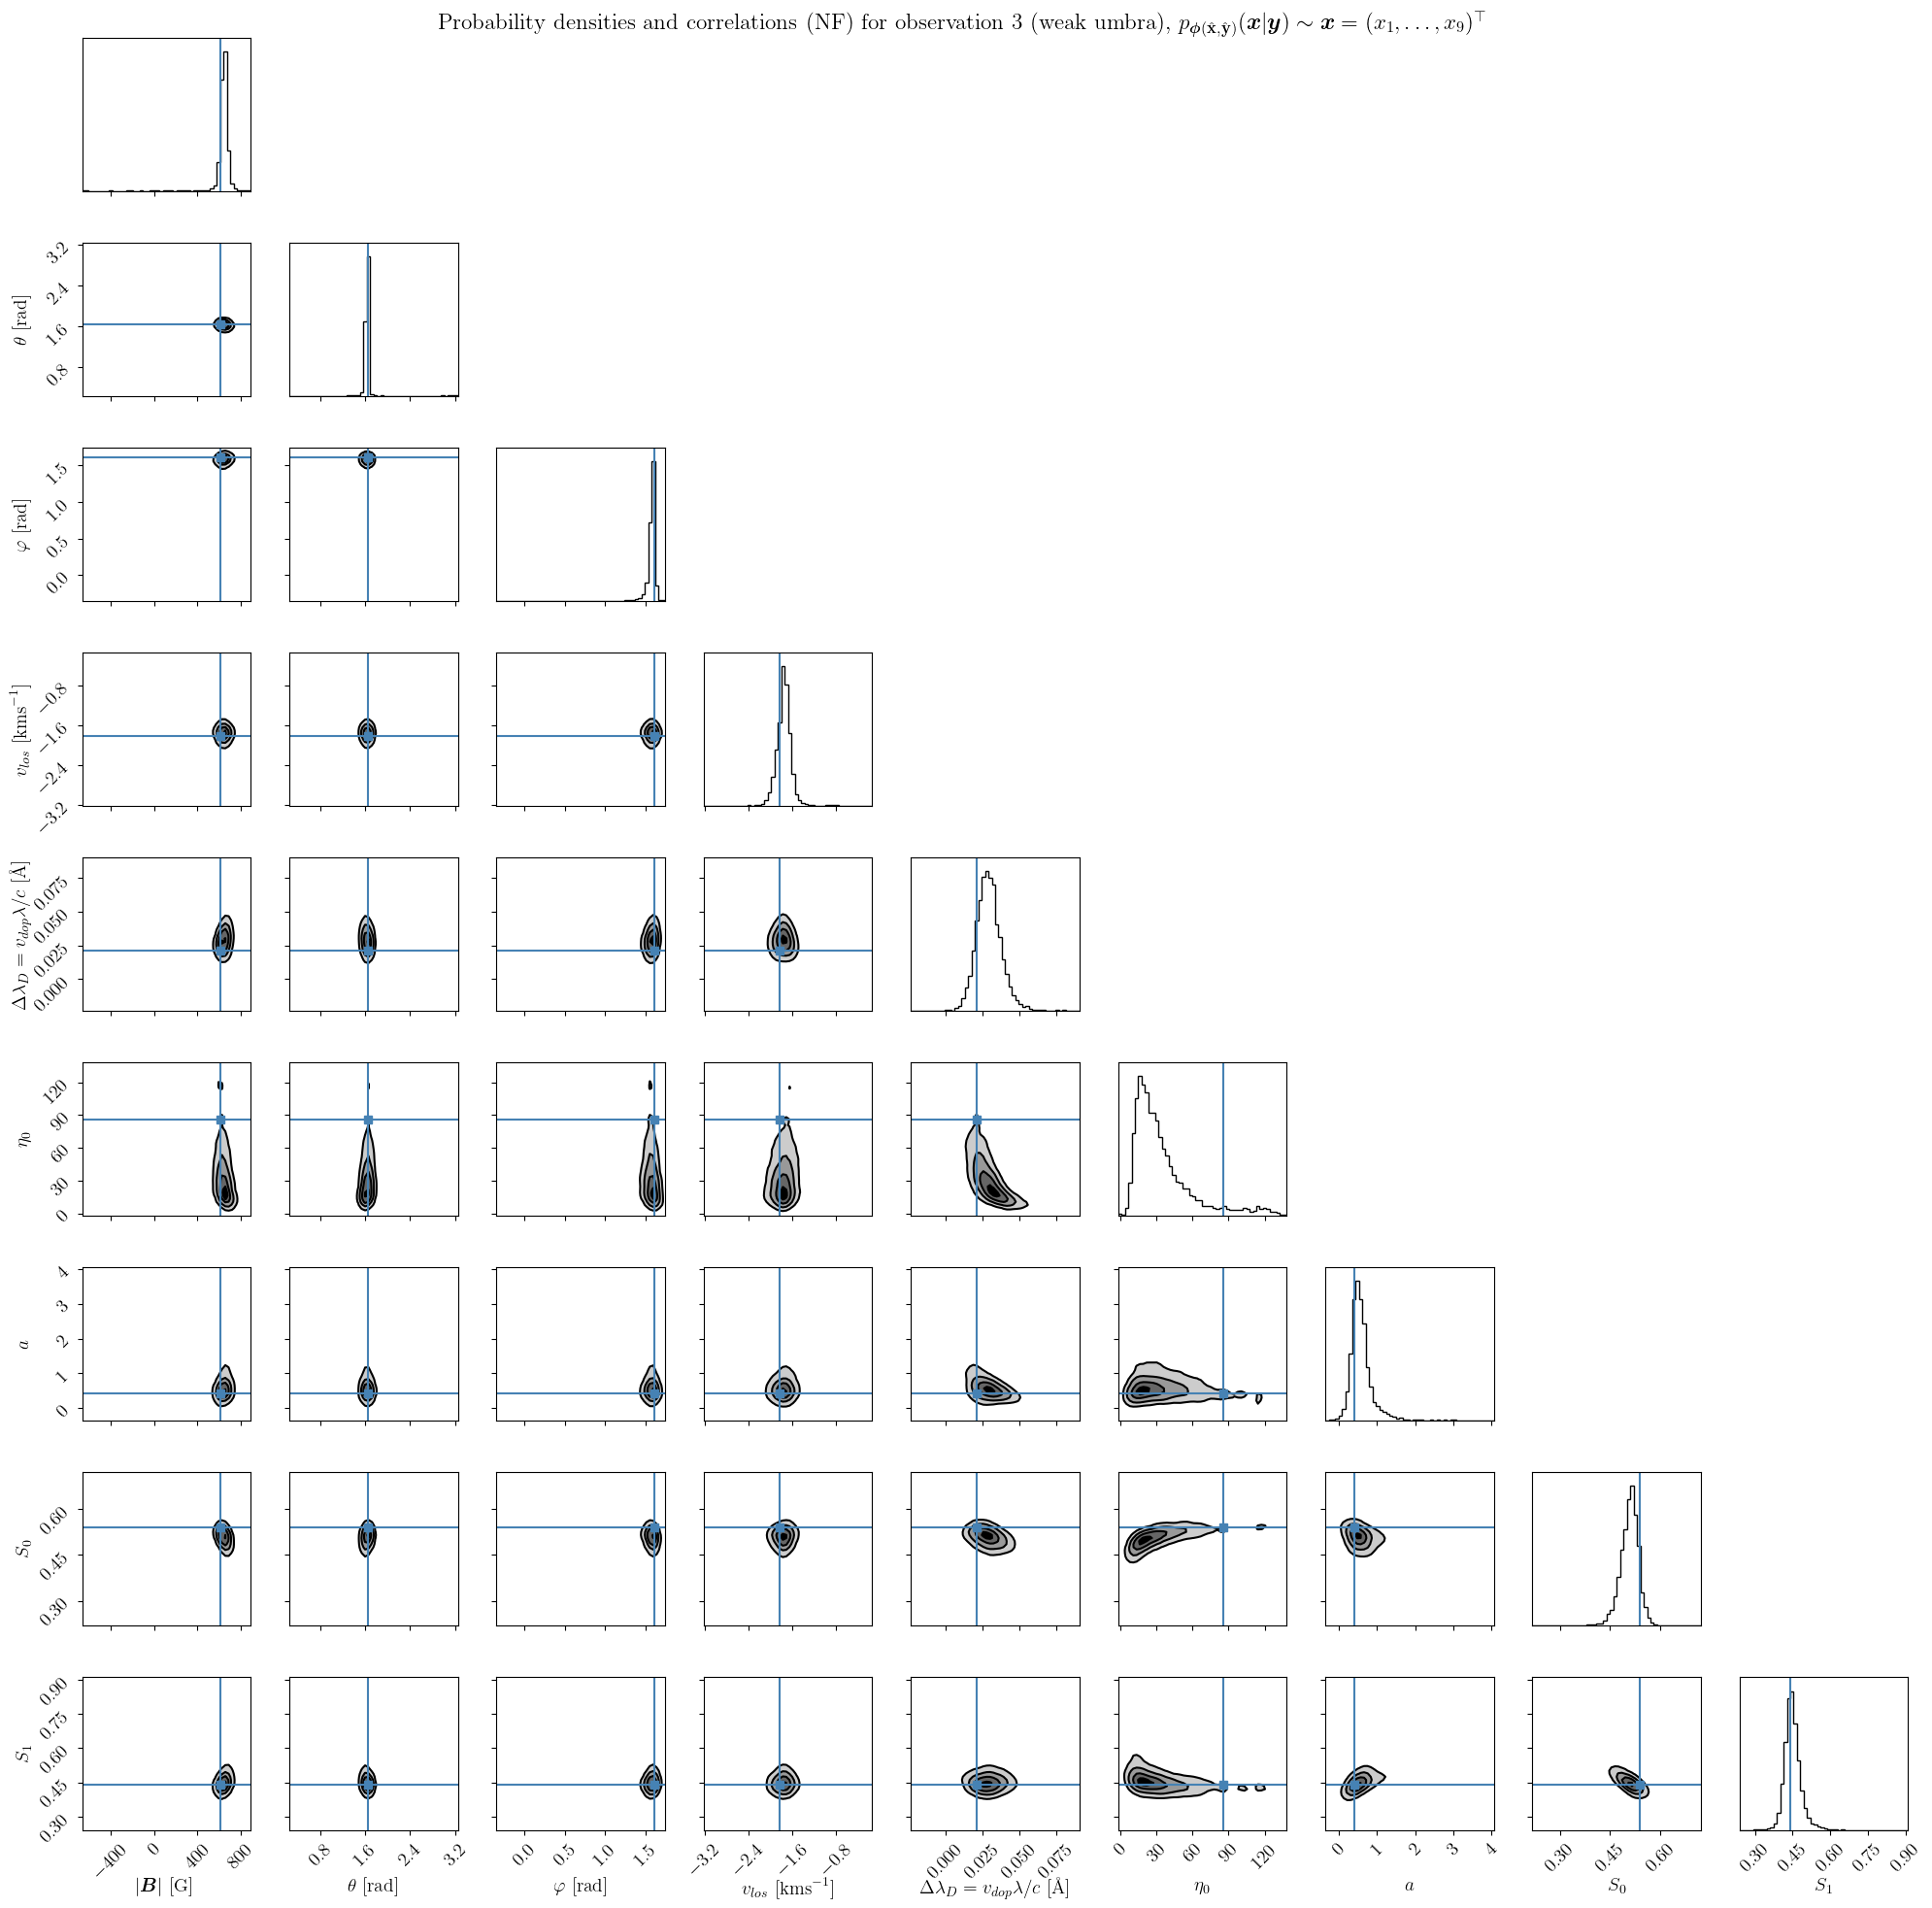

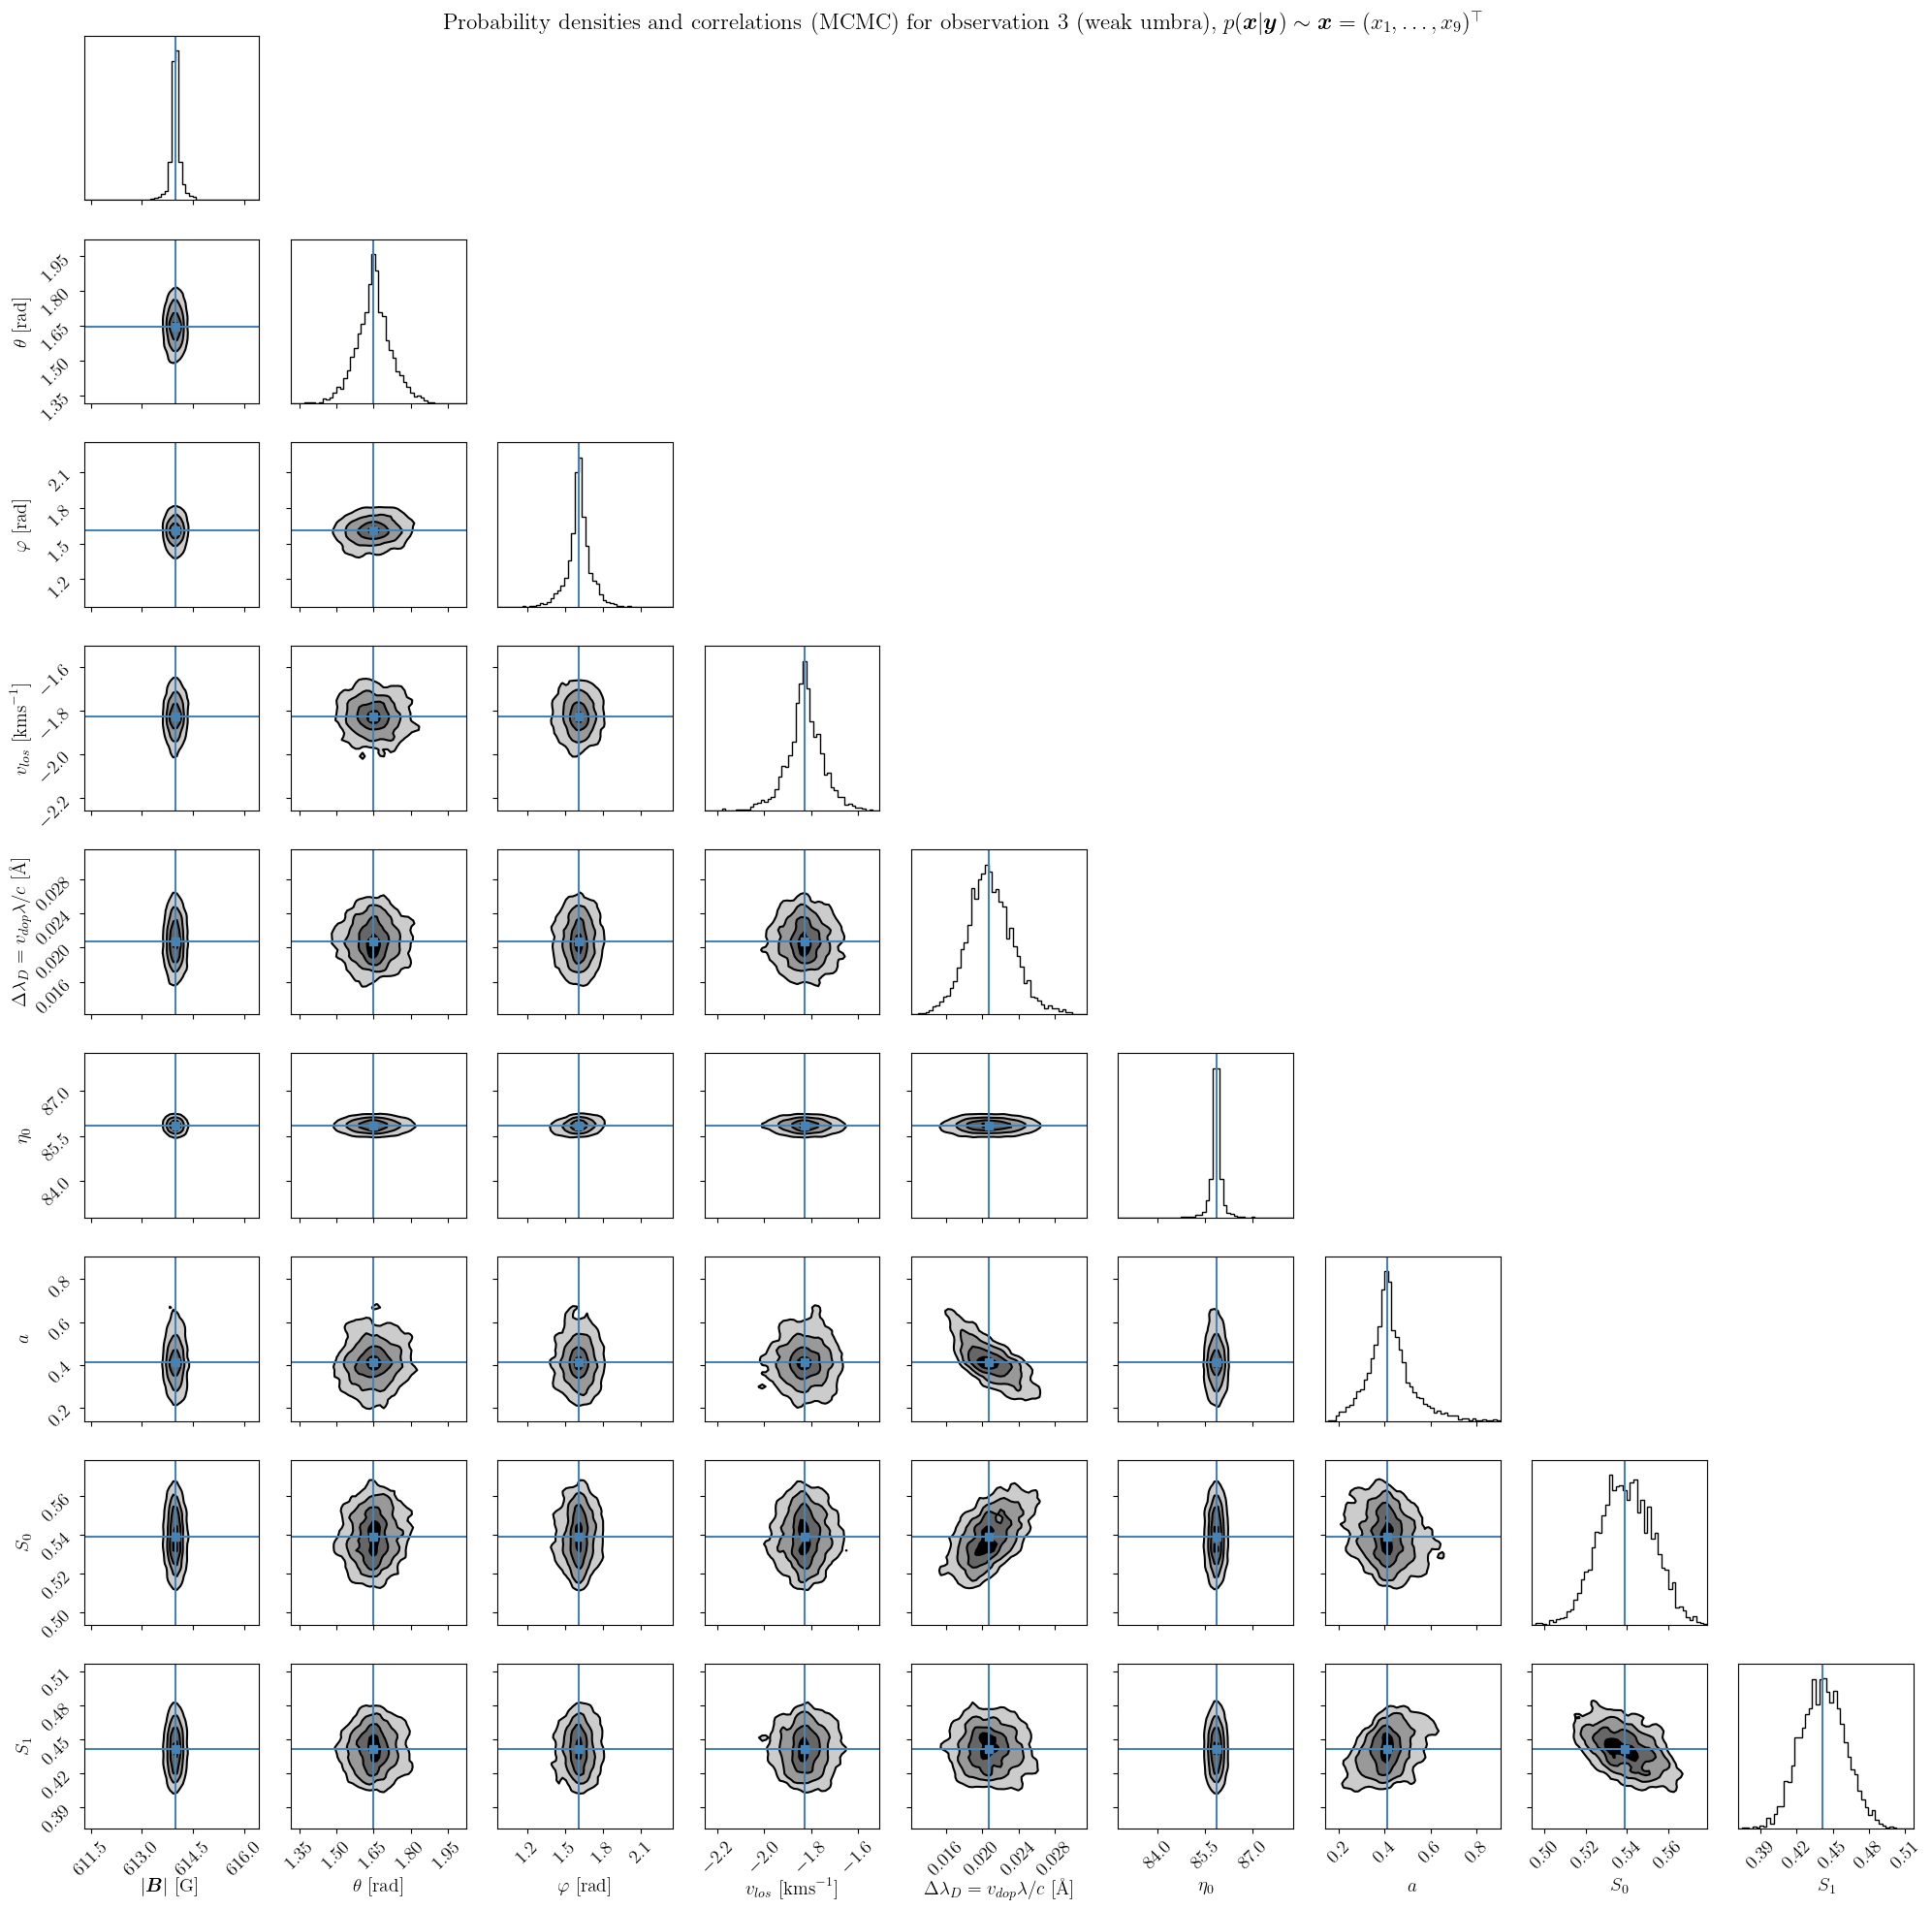

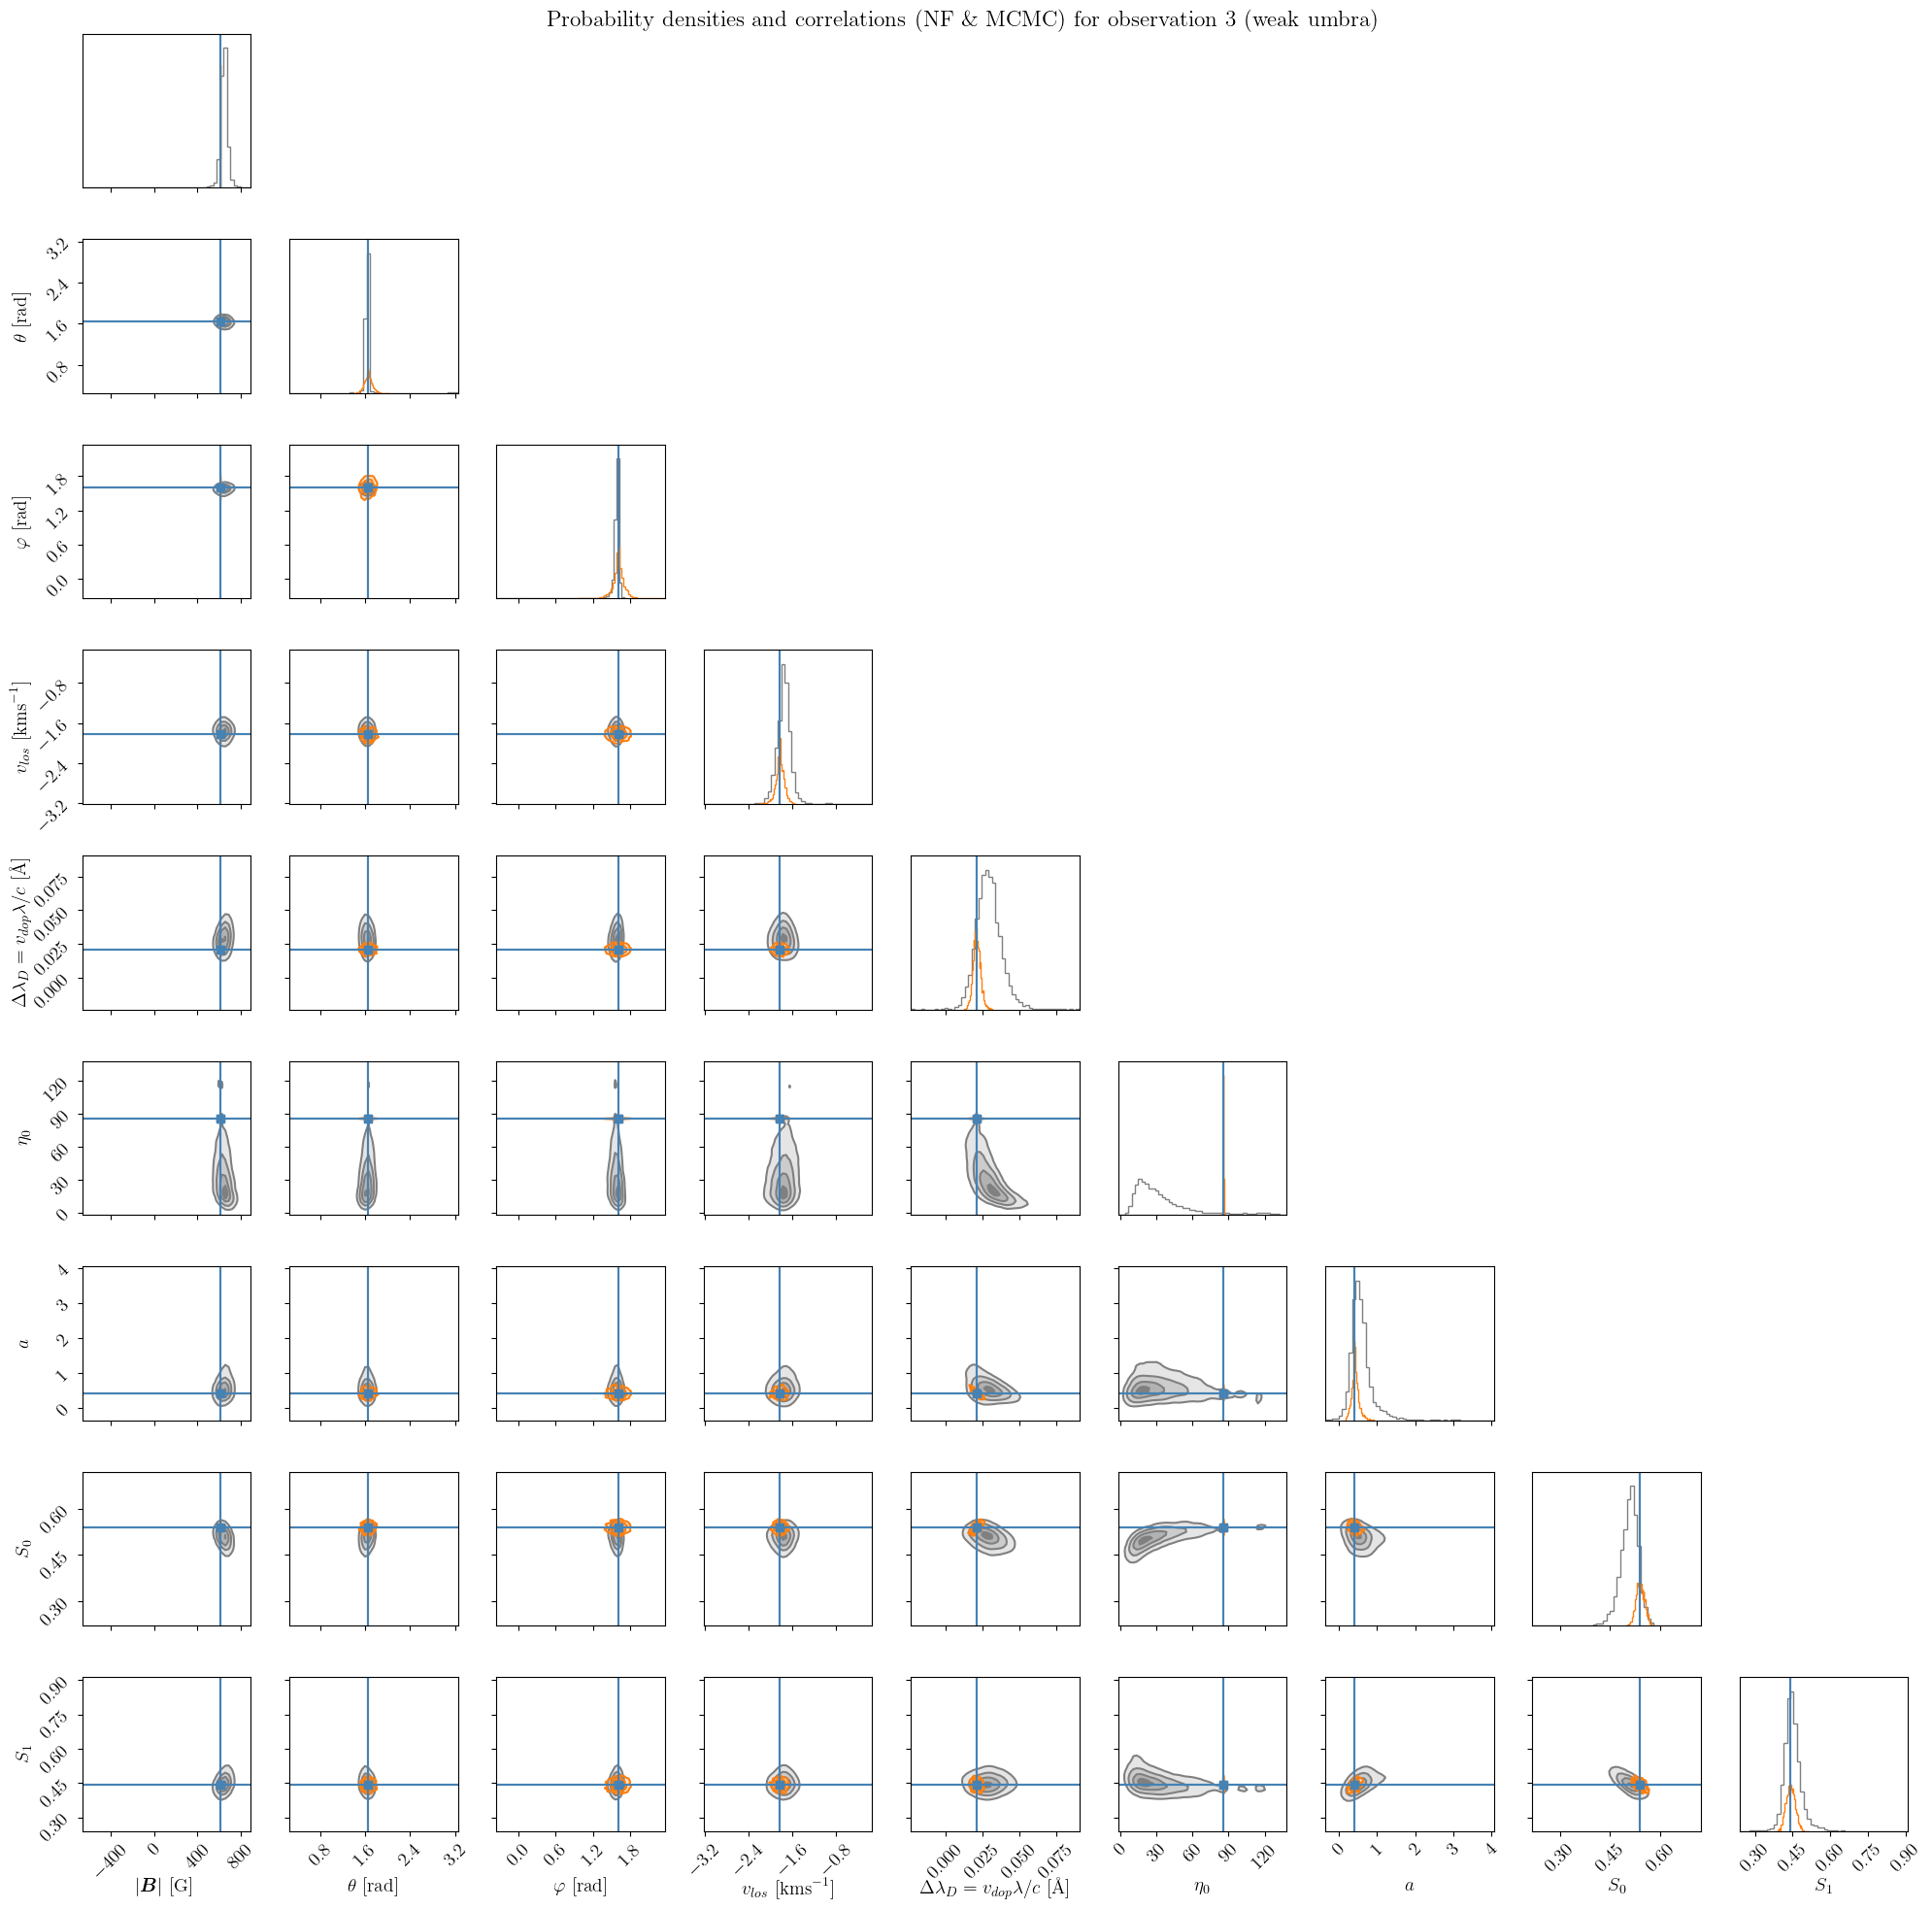

In [36]:
# Take test sample 1 (quiet sun)
expval = expval3
expobs = expobs3

z_exp = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(settings.exp_samples,))
y_exp = torch.tensor(np.repeat(expobs[None,:], 1, axis=0))
y_exp_std = torch.tensor(y_probe_scaler.transform(y_exp), dtype=torch.float32)

# Sample from the flow using the testobservation y_exp as context
rec_x_std = flow.sample(settings.exp_samples, context=y_exp_std)
rec_x_std = rec_x_std.detach().numpy()
rec_x_nf = x_probe_scaler.inverse_transform(rec_x_std[0])

# Plot Stokes profiles
plot_stokes_single(expobs, regions_dict[0][0][0], stokes_labels, title='Stokes parameters for observation 3 (weak umbra)', savename='nf-milne-eddington-example-6-corner-spectrum-3-nf-nflows-piecewisequadratic.pdf')

# Produce corner plot
figure = corner.corner(rec_x_nf, labels=l_units, truths=expval, show_titles=False, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
plt.suptitle('Probability densities and correlations (NF) for observation 3 (weak umbra), $p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{9})^\\top$')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-6-corner-3-nf-nflows-piecewisequadratic.pdf')

# Do MCMC sampling
mcmc_model = Bayesian_Inference(expval, min_x-0.1*mean_x, max_x+0.1*mean_x, noise=1e-2)
rec_x_mcmc = mcmc_model.sample()

# Produce corner plot
figure = corner.corner(rec_x_mcmc, labels=l_units, truths=expval, show_titles=False, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
plt.suptitle('Probability densities and correlations (MCMC) for observation 3 (weak umbra), $p(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{9})^\\top$')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-6-corner-3-mcmc-nflows-piecewisequadratic.pdf')

# Calculate weights
weights_nf = np.ones_like(rec_x_nf[:,0])/len(rec_x_nf[:,0])
weights_mcmc = np.ones_like(rec_x_mcmc[:,0])/len(rec_x_mcmc[:,0])

# Produce corner plot
figure = corner.corner(rec_x_nf, labels=l_units, truths=expval, show_titles=False, color='Gray', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, weights=weights_nf)
_ = corner.corner(rec_x_mcmc, labels=l_units, truths=expval, show_titles=False, color='C1', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, weights=weights_mcmc, fig=figure)
plt.suptitle('Probability densities and correlations (NF \& MCMC) for observation 3 (weak umbra)')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-6-corner-3-nf-mcmc-nflows-piecewisequadratic.pdf')

## NF and MCMC inversion of observation #4

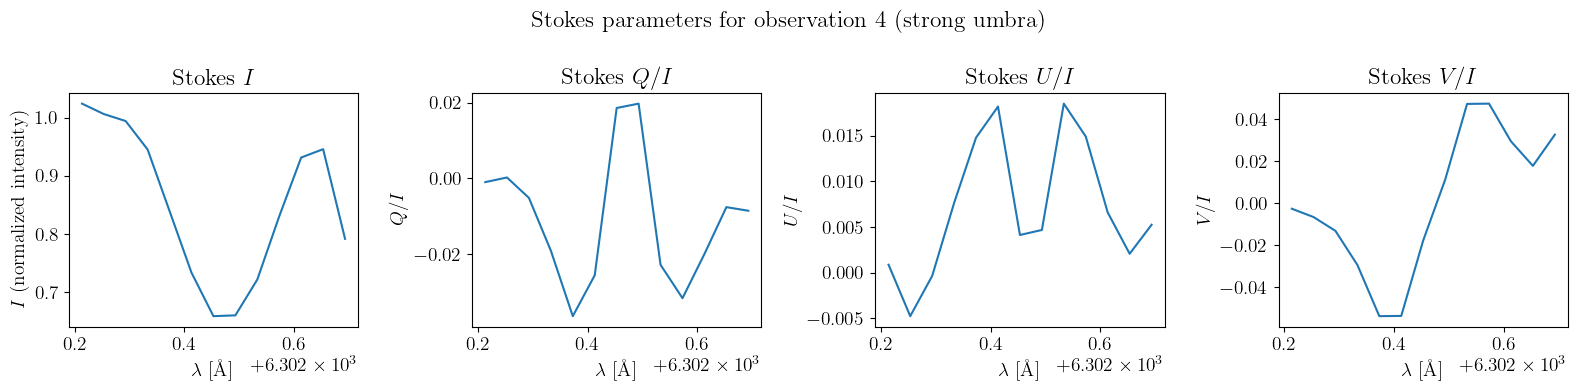

line::line: Initialized [6302.493100] ->   3 Zeeman components
  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]/home/dz/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:48<00:00, 20.47it/s]


pyMilne::dealloc: cleaning-up...


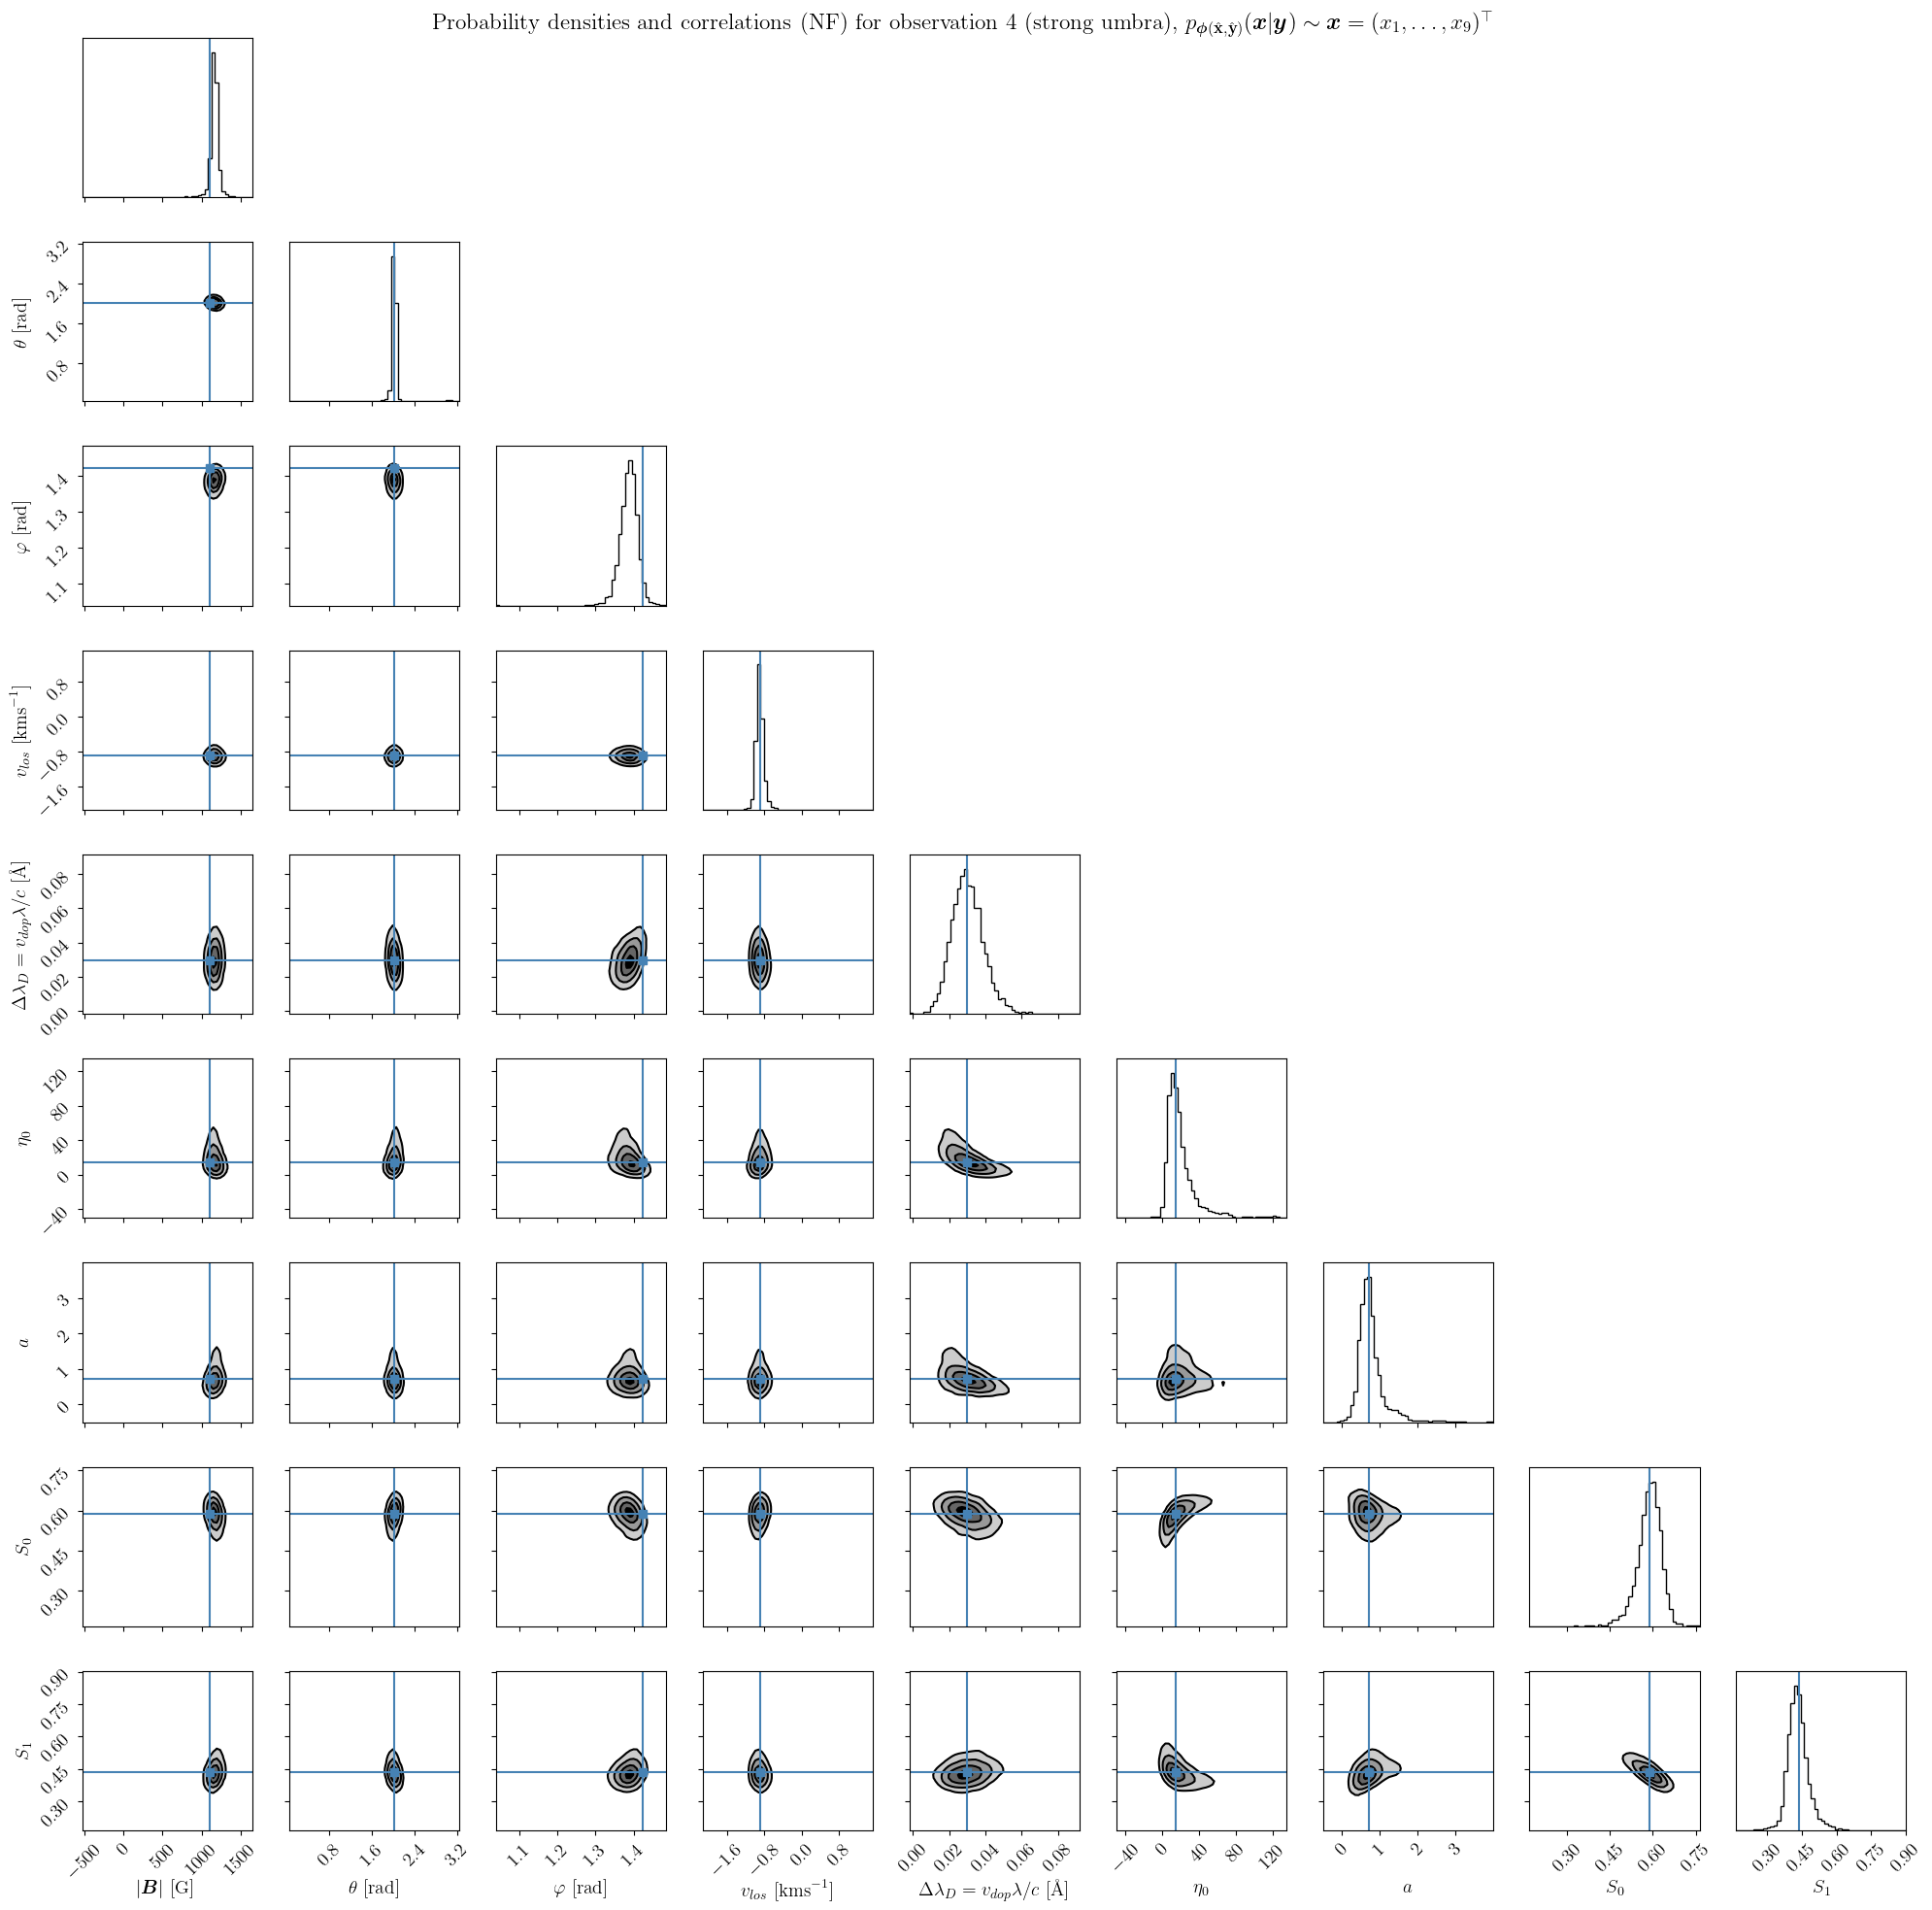

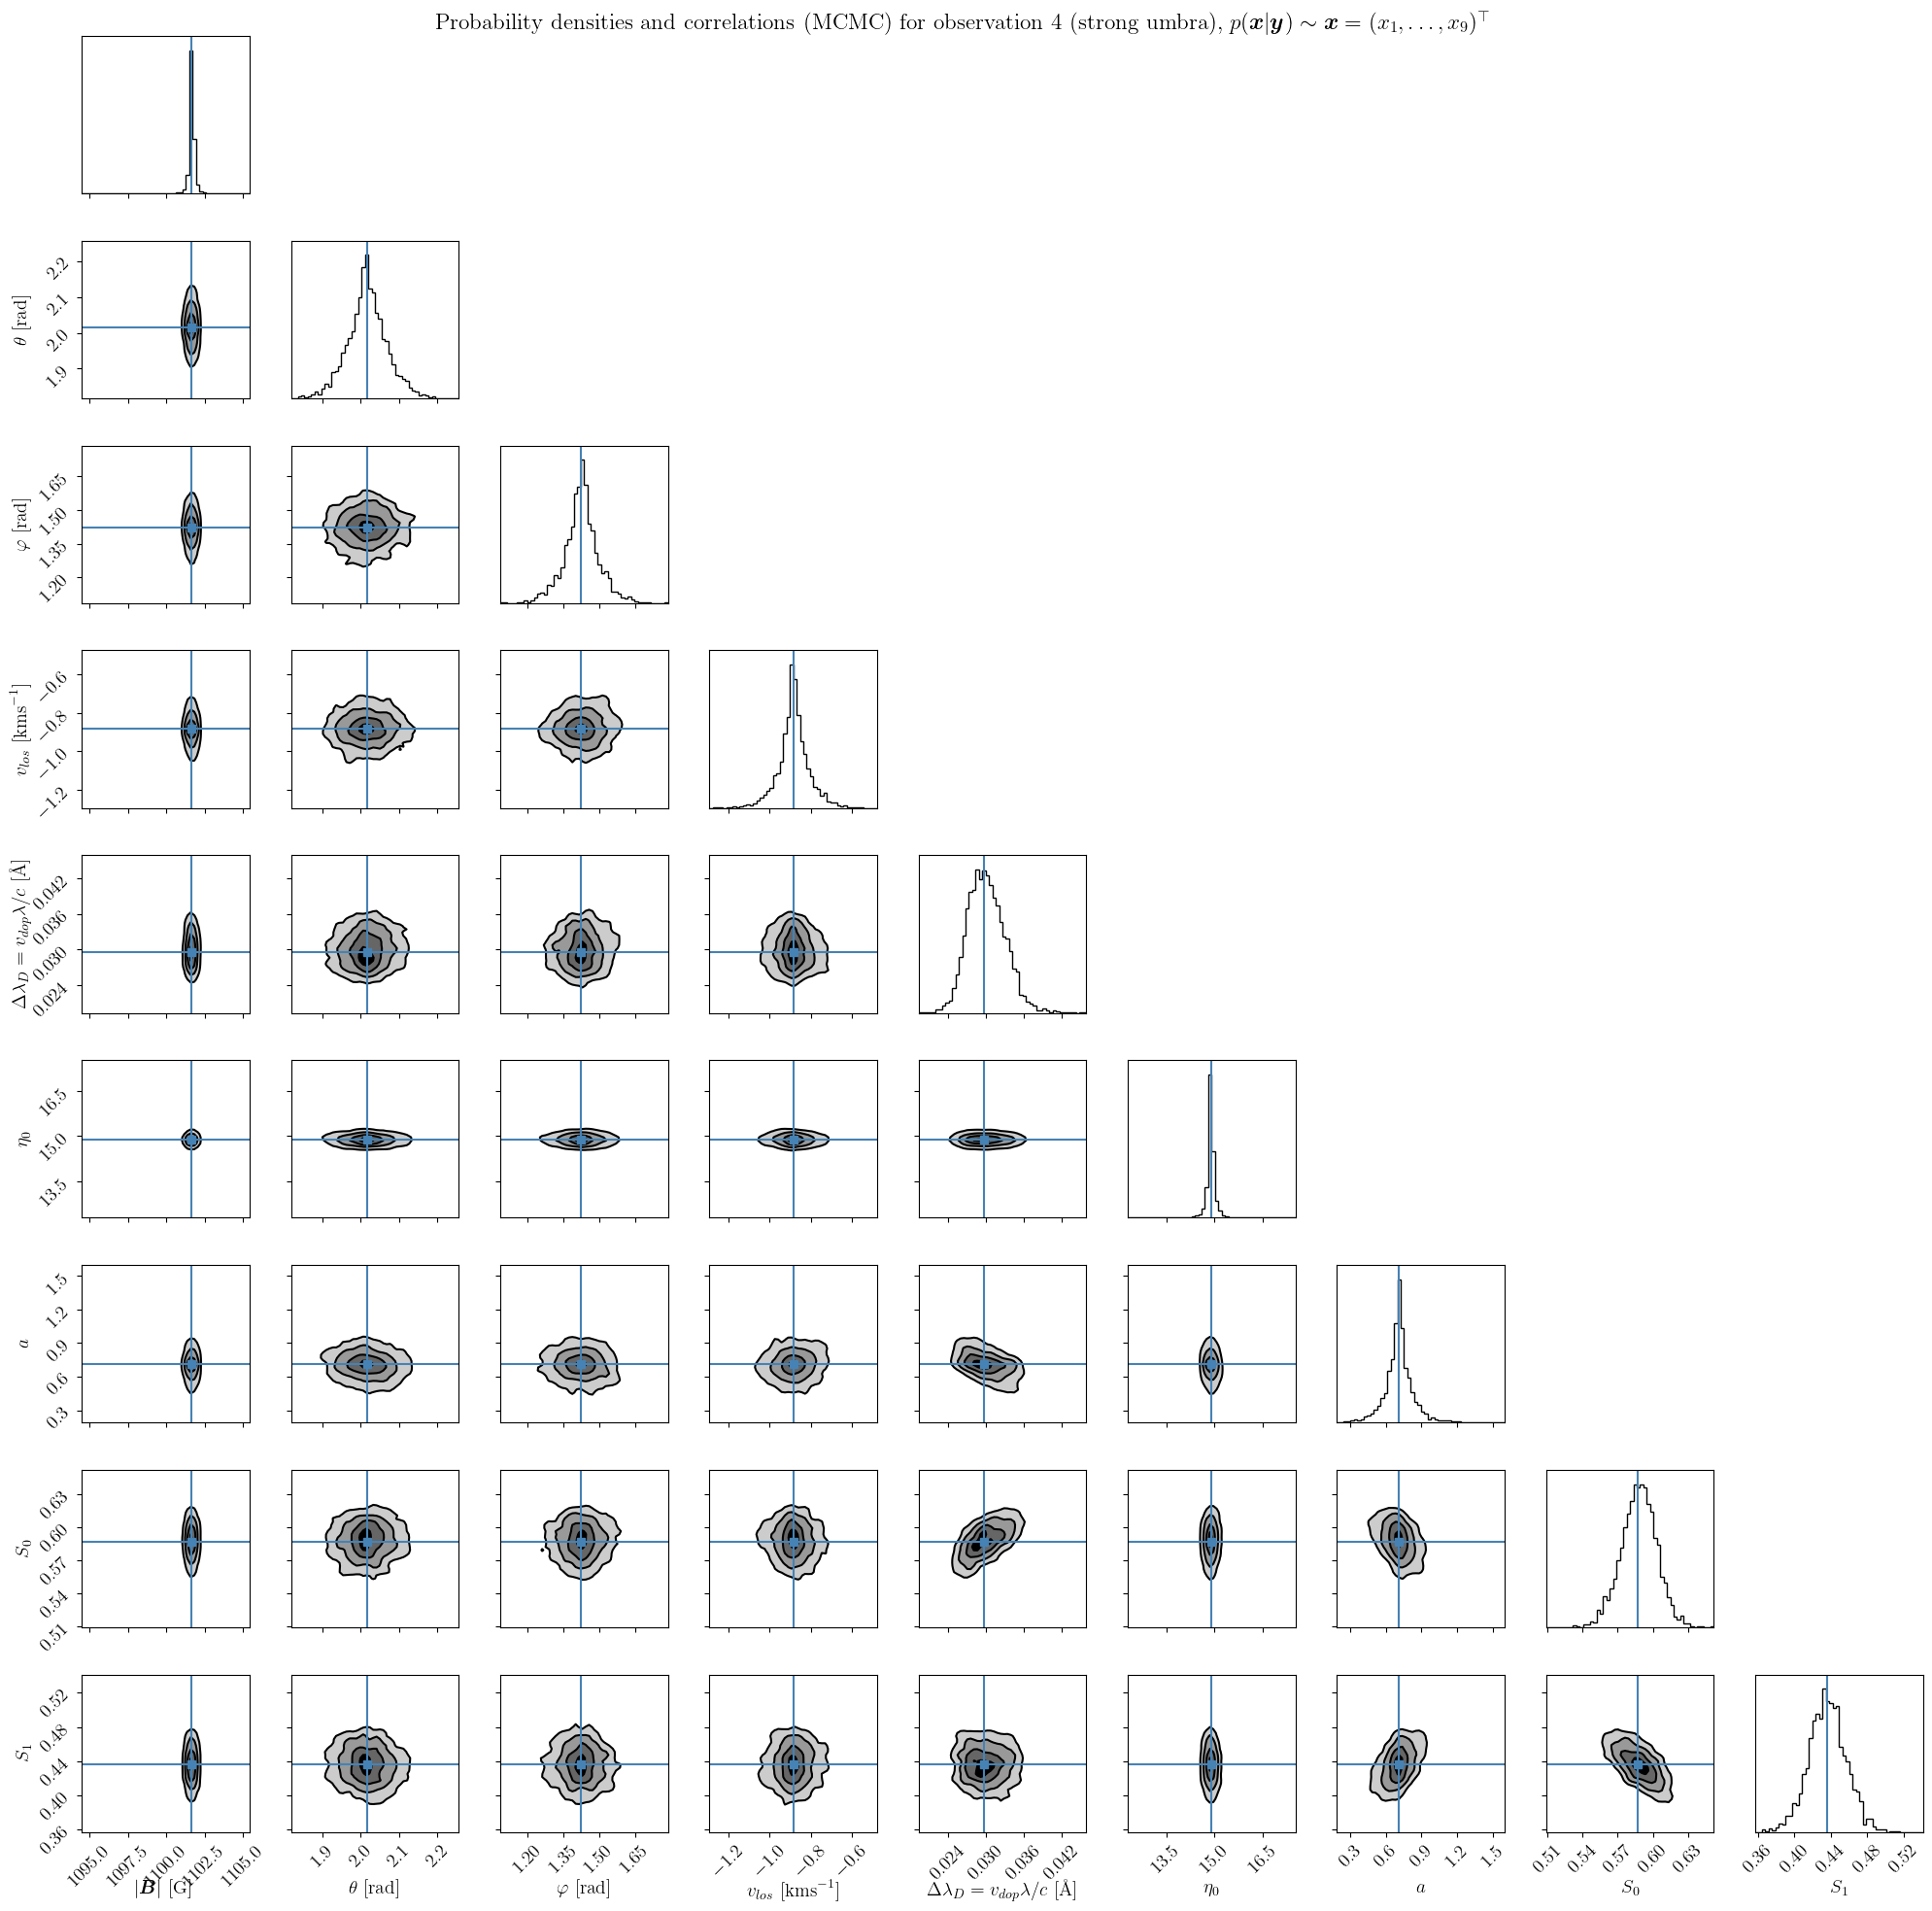

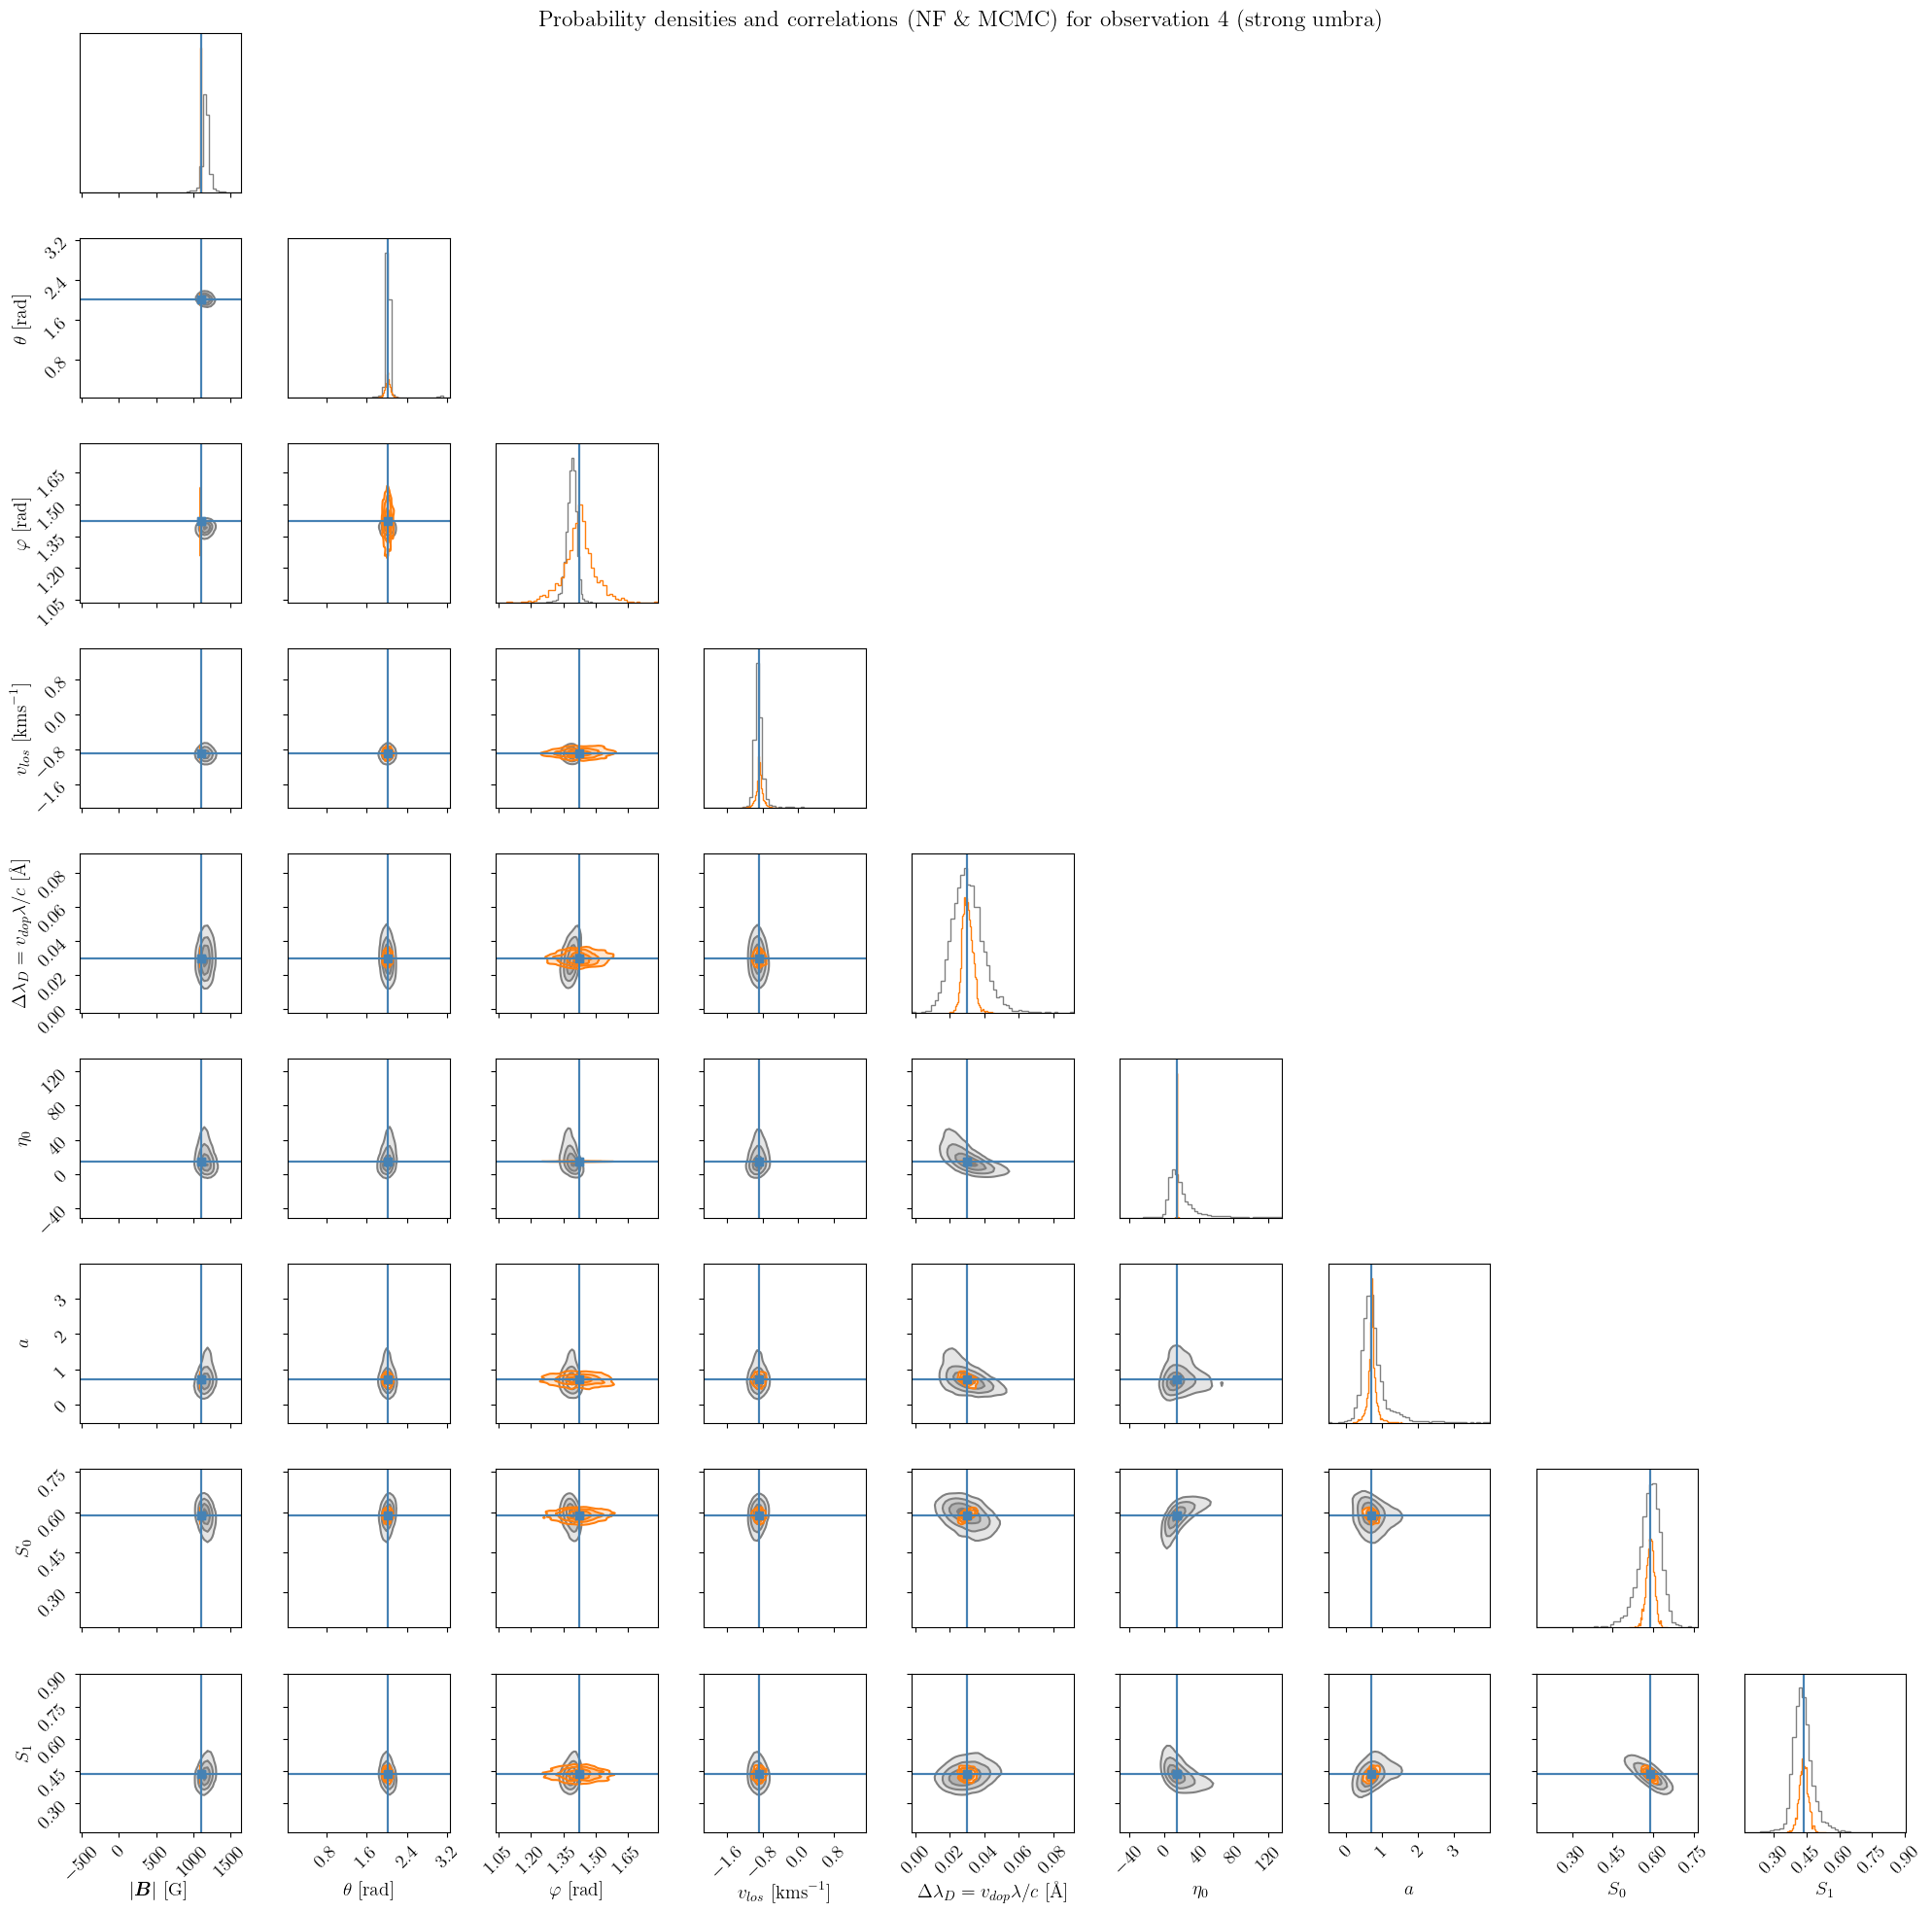

In [37]:
# Take test sample 1 (quiet sun)
expval = expval4
expobs = expobs4

z_exp = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(settings.exp_samples,))
y_exp = torch.tensor(np.repeat(expobs[None,:], 1, axis=0))
y_exp_std = torch.tensor(y_probe_scaler.transform(y_exp), dtype=torch.float32)

# Sample from the flow using the testobservation y_exp as context
rec_x_std = flow.sample(settings.exp_samples, context=y_exp_std)
rec_x_std = rec_x_std.detach().numpy()
rec_x_nf = x_probe_scaler.inverse_transform(rec_x_std[0])

# Plot Stokes profiles
plot_stokes_single(expobs, regions_dict[0][0][0], stokes_labels, title='Stokes parameters for observation 4 (strong umbra)', savename='nf-milne-eddington-example-6-corner-spectrum-4-nf-nflows-piecewisequadratic.pdf')

# Produce corner plot
figure = corner.corner(rec_x_nf, labels=l_units, truths=expval, show_titles=False, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
plt.suptitle('Probability densities and correlations (NF) for observation 4 (strong umbra), $p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{9})^\\top$')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-6-corner-4-nf-nflows-piecewisequadratic.pdf')

# Do MCMC sampling
mcmc_model = Bayesian_Inference(expval, min_x-0.1*mean_x, max_x+0.1*mean_x, noise=1e-2)
rec_x_mcmc = mcmc_model.sample()

# Produce corner plot
figure = corner.corner(rec_x_mcmc, labels=l_units, truths=expval, show_titles=False, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
plt.suptitle('Probability densities and correlations (MCMC) for observation 4 (strong umbra), $p(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{9})^\\top$')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-6-corner-4-mcmc-nflows-piecewisequadratic.pdf')

# Calculate weights
weights_nf = np.ones_like(rec_x_nf[:,0])/len(rec_x_nf[:,0])
weights_mcmc = np.ones_like(rec_x_mcmc[:,0])/len(rec_x_mcmc[:,0])

# Produce corner plot
figure = corner.corner(rec_x_nf, labels=l_units, truths=expval, show_titles=False, color='Gray', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, weights=weights_nf)
_ = corner.corner(rec_x_mcmc, labels=l_units, truths=expval, show_titles=False, color='C1', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, weights=weights_mcmc, fig=figure)
plt.suptitle('Probability densities and correlations (NF \& MCMC) for observation 4 (strong umbra)')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-6-corner-4-nf-mcmc-nflows-piecewisequadratic.pdf')

# Appendix: Comment on discrepancy between MCMC and NF results
The discrepancy between the MCMC and NF results is likely due to the low number of wavelength points considered in the data used to train the normalizing flow on. Furthermore, the consideration of the full Stokes vector could introduce additional uncertainty to the normalizing flow training data, whereas only intensity values were considered in experiments done by other people, such as __[[Diaz Baso et al., 2022]](https://www.aanda.org/articles/aa/full_html/2022/03/aa42018-21/aa42018-21.html)__.